<a href="https://colab.research.google.com/github/PimonwunPhoomsrikaew/Prediction_Stroke/blob/main/Prediction_stroke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INSTALL

In [54]:
!pip install --upgrade mne

In [53]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: 

#Import Lib

In [ ]:
import os
import mne
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM

from sklearn.pipeline import make_pipeline
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, classification_report, ConfusionMatrixDisplay


#Define the filter frequencies

In [ ]:
# Define the filter frequencies
highpass_freq = 1  # Hz
lowpass_freq = 35  # Hz
sampling_rate = 256  # Hz

channel_name = {'EEG Fp1-Cz': 'Fp1', 'EEG Fp2-Cz': 'Fp2', 'EEG F7-Cz': 'F7', 'EEG F8-Cz': 'F8', 'EEG T3-Cz': 'T3', 'EEG T4-Cz': 'T4',  'EEG T5-Cz': 'T5', 'EEG T6-Cz': 'T6', 'EEG O1-Cz': 'O1', 'EEG O2-Cz': 'O2', 'EEG F3-Cz': 'F3', 'EEG F4-Cz': 'F4', 'EEG C3-Cz': 'C3', 'EEG C4-Cz': 'C4', 'EEG P3-Cz': 'P3', 'EEG P4-Cz': 'P4'}
channel_dropout = ['E1/Pg1-Cz', 'E2/Pg2-Cz','EEG Fz-Cz', 'EEG Pz-Cz', 'T1-Cz', 'T2-Cz', 'EEG A1-Cz', 'EEG A2-Cz', 'EEG Cz-Cz', '1A-1R', '2A-2R', '3A-3R', '4A-4R', '5A-5R', '6A-6R', '7A-7R', 'Status']


#ICA Process

In [ ]:
def ica_process(raw_data):
    raw_data.apply_function(lambda x: x - x.mean(), picks='eeg', channel_wise=True)
    eeg_data = raw_data.get_data().T
    ica = FastICA(n_components=eeg_data.shape[1], random_state=42)
    components = ica.fit_transform(eeg_data)
    components_to_remove = [0, 1, 5, 6, 10]
    for comp in components_to_remove:
        components[:, comp] = 0
    restored = ica.inverse_transform(components)
    return restored


#Preprocess Data



In [ ]:
def preprocess_data(file_name, group):
    print('-----Preprocess Data-----')
    iir_params = dict(order=5, ftype='butter')
    data = mne.io.read_raw_edf(file_name, preload=True)
    data.drop_channels([ch for ch in data.ch_names if any(dc in ch for dc in channel_dropout)])
    max_time = data.times[-1]
    data.crop(0, min(1800, max_time))
    data.rename_channels({ch: channel_name.get(ch, channel_name.get(ch.replace('EEG ', ''), ch)) for ch in data.ch_names})
    data.resample(sampling_rate)
    data.apply_function(lambda x: x * 1e6, picks='all', channel_wise=True)
    data.notch_filter(50, method='iir', iir_params=iir_params)
    data.filter(highpass_freq, lowpass_freq, method='iir', iir_params=iir_params)

    # restored_data = ica_process(data)  # Move ICA processing

    # Specify bipolar electrode pairs (customize this as per your EEG channels)
    anode  = ['Fp1', 'F7', 'T3', 'T5', 'Fp2', 'F8', 'T4', 'T6','Fp1', 'F3', 'C3', 'P3','Fp2', 'F4', 'C4', 'P4']
    cathode = ['F7', 'T3', 'T5', 'O1', 'F8', 'T4', 'T6', 'O2','F3', 'C3', 'P3', 'O1', 'F4', 'C4', 'P4', 'O2']

    # Create bipolar reference
    restored_data = mne.set_bipolar_reference(data, anode=anode, cathode=cathode)
    print('-----restores_data-----' + str(restored_data))
    print('-----restores_data info-----' + str(restored_data.info))
    file_base_name = os.path.basename(file_name)
    file_id = os.path.splitext(file_base_name)[0]
    return restored_data, restored_data.info, file_id, group


In [ ]:
# Function to preprocess all data
def preprocess_all_data():
    hc_files = glob.glob("/content/drive/MyDrive/EEG_PROJECT/EEG_ANALYSIS/data_set_Cz/HC/*.edf")
    st_files = glob.glob("/content/drive/MyDrive/EEG_PROJECT/EEG_ANALYSIS/data_set_Cz/ST/*.edf")

    hc_preprocessed = [preprocess_data(file, 0) for file in hc_files]  # Group = 0 for HC
    st_preprocessed = [preprocess_data(file, 1) for file in st_files]  # Group = 1 for ST

    return hc_preprocessed, st_preprocessed

In [ ]:
hc_preprocessed, st_preprocessed = preprocess_all_data()

-----Preprocess Data-----
Extracting EDF parameters from /content/drive/MyDrive/EEG_PROJECT/EEG_ANALYSIS/data_set_Cz/HC/HC_007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3617999  =      0.000 ...  1808.999 secs...


KeyboardInterrupt: 

In [ ]:
print(len(hc_preprocessed))
print(len(st_preprocessed))

22
31
(<RawEDF | HC_007.edf, 18 x 460800 (1800.0 s), ~63.3 MB, data loaded>, <Info | 10 non-empty values
 bads: []
 ch_names: EEG Fz-Cz, EEG Pz-Cz, Fp1-F7, F7-T3, T3-T5, T5-O1, Fp2-F8, ...
 chs: 18 EEG
 custom_ref_applied: True
 dig: 0 items
 highpass: 1.0 Hz
 lowpass: 35.0 Hz
 meas_date: 2024-03-04 14:44:03 UTC
 nchan: 18
 projs: []
 sfreq: 256.0 Hz
 subject_info: 5 items (dict)
>, 'HC_007', 0)
(<RawEDF | ST_001.edf, 18 x 460801 (1800.0 s), ~63.3 MB, data loaded>, <Info | 10 non-empty values
 bads: []
 ch_names: EEG Fz-Cz, EEG Pz-Cz, Fp1-F7, F7-T3, T3-T5, T5-O1, Fp2-F8, ...
 chs: 18 EEG
 custom_ref_applied: True
 dig: 0 items
 highpass: 1.0 Hz
 lowpass: 35.0 Hz
 meas_date: 2024-02-21 10:33:41 UTC
 nchan: 18
 projs: []
 sfreq: 256.0 Hz
 subject_info: 4 items (dict)
>, 'ST_001', 1)


NameError: name 'info' is not defined

##Difference Feature Power and QEEG

In [ ]:
def extract_features(restored_data, info, file_id, group):
    print('-----Extract Feature -----')
     # Get the data from restored_data using get_data()
    restored_array = restored_data.get_data().T

    restored_raw = mne.io.RawArray(restored_array, info)
    spectrum = restored_raw.compute_psd(method='welch', fmin=0.5, fmax=30, n_fft=800)

    psd, freqs = spectrum.get_data(return_freqs=True)
    psd_normal = psd / np.mean(psd, axis=-1, keepdims=True)

    frequency_bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 12),
        'Beta': (12, 30),
        'Gamma': (30, 40)
    }

    print('-----band_power-----')
    def band_power(psd, freqs, band):
        band_freqs = np.logical_and(freqs >= band[0], freqs <= band[1])
        return np.mean(psd[:, band_freqs], axis=1)

    band_powers = {band: band_power(psd_normal, freqs, frequency_bands[band]) for band in frequency_bands}

    print('-----Compute QEEG features-----')
    dar = band_powers['Delta'] / band_powers['Alpha']
    dtr = band_powers['Delta'] / band_powers['Theta']
    dtar = (band_powers['Delta'] + band_powers['Theta']) / band_powers['Alpha']
    tar = band_powers['Theta'] / band_powers['Alpha']
    tbr = band_powers['Theta'] / band_powers['Beta']
    tbar = band_powers['Theta'] / (band_powers['Alpha'] + band_powers['Beta'])
    print('-----Calculate Difference-----')

    delta_power_diff_Fp1_Fp2 = band_powers['Delta'][0] - band_powers['Delta'][1]
    theta_power_diff_Fp1_Fp2 = band_powers['Theta'][0] - band_powers['Theta'][1]
    alpha_power_diff_Fp1_Fp2 = band_powers['Alpha'][0] - band_powers['Alpha'][1]
    dar_Fp1_Fp2 = dar[0] - dar[1]
    dtr_Fp1_Fp2 = dtr[0] - dtr[1]
    dtar_Fp1_Fp2 = dtar[0] - dtar[1]

    delta_power_diff_F3_F4 = band_powers['Delta'][3] - band_powers['Delta'][5]
    theta_power_diff_F3_F4 = band_powers['Theta'][3] - band_powers['Theta'][5]
    alpha_power_diff_F3_F4 = band_powers['Alpha'][3] - band_powers['Alpha'][5]
    dar_F3_F4 = dar[3] - dar[5]
    dtr_F3_F4 = dtr[3] - dtr[5]
    dtar_F3_F4 = dtar[3] - dtar[5]

    delta_power_diff_F7_F8 = band_powers['Delta'][2] - band_powers['Delta'][6]
    theta_power_diff_F7_F8 = band_powers['Theta'][2] - band_powers['Theta'][6]
    alpha_power_diff_F7_F8 = band_powers['Alpha'][2] - band_powers['Alpha'][6]
    dar_F7_F8 = dar[2] - dar[6]
    dtr_F7_F8 = dtr[2] - dtr[6]
    dtar_F7_F8 = dtar[2] - dtar[6]

    delta_power_diff_A1_A2 = band_powers['Delta'][7] - band_powers['Delta'][12]
    theta_power_diff_A1_A2 = band_powers['Theta'][7] - band_powers['Theta'][12]
    alpha_power_diff_A1_A2 = band_powers['Alpha'][7] - band_powers['Alpha'][12]
    dar_A1_A2 = dar[7] - dar[12]
    dtr_A1_A2 = dtr[7] - dtr[12]
    dtar_A1_A2 = dtar[7] - dtar[12]

    delta_power_diff_T3_T4 = band_powers['Delta'][8] - band_powers['Delta'][11]
    theta_power_diff_T3_T4 = band_powers['Theta'][8] - band_powers['Theta'][11]
    alpha_power_diff_T3_T4 = band_powers['Alpha'][8] - band_powers['Alpha'][11]
    dar_T3_T4 = dar[8] - dar[11]
    dtr_T3_T4 = dtr[8] - dtr[11]
    dtar_T3_T4 = dtar[8] - dtar[11]

    delta_power_diff_T5_T6 = band_powers['Delta'][13] - band_powers['Delta'][17]
    theta_power_diff_T5_T6 = band_powers['Theta'][13] - band_powers['Theta'][17]
    alpha_power_diff_T5_T6 = band_powers['Alpha'][13] - band_powers['Alpha'][17]
    dar_T5_T6 = dar[13] - dar[17]
    dtr_T5_T6 = dtr[13] - dtr[17]
    dtar_T5_T6 = dtar[13] - dtar[17]

    delta_power_diff_P3_P4 = band_powers['Delta'][14] - band_powers['Delta'][16]
    theta_power_diff_P3_P4 = band_powers['Theta'][14] - band_powers['Theta'][16]
    alpha_power_diff_P3_P4 = band_powers['Alpha'][14] - band_powers['Alpha'][16]
    dar_P3_P4 = dar[14] - dar[16]
    dtr_P3_P4 = dtr[14] - dtr[16]
    dtar_P3_P4 = dtar[14] - dtar[16]

    delta_power_diff_O1_O2 = band_powers['Delta'][18] - band_powers['Delta'][19]
    theta_power_diff_O1_O2 = band_powers['Theta'][18] - band_powers['Theta'][19]
    alpha_power_diff_O1_O2 = band_powers['Alpha'][18] - band_powers['Alpha'][19]
    dar_O1_O2 = dar[18] - dar[19]
    dtr_O1_O2 = dtr[18] - dtr[19]
    dtar_O1_O2 = dtar[18] - dtar[19]

    print('-----features-----')
    features = {
        'id': file_id,

        'delta_power_diff_Fp1_Fp2': delta_power_diff_Fp1_Fp2,
        'theta_power_diff_Fp1_Fp2': theta_power_diff_Fp1_Fp2,
        'alpha_power_diff_Fp1_Fp2': alpha_power_diff_Fp1_Fp2,
        'dar_Fp1_Fp2': dar_Fp1_Fp2,
        'dtr_Fp1_Fp2': dtr_Fp1_Fp2,
        'dtar_Fp1_Fp2': dtar_Fp1_Fp2,

        'delta_power_diff_F3_F4': delta_power_diff_F3_F4,
        'theta_power_diff_F3_F4': theta_power_diff_F3_F4,
        'alpha_power_diff_F3_F4': alpha_power_diff_F3_F4,
        'dar_F3_F4': dar_F3_F4,
        'dtr_F3_F4': dtr_F3_F4,
        'dtar_F3_F4': dtar_F3_F4,

        'delta_power_diff_F7_F8': delta_power_diff_F7_F8,
        'theta_power_diff_F7_F8': theta_power_diff_F7_F8,
        'alpha_power_diff_F7_F8': alpha_power_diff_F7_F8,
        'dar_F7_F8': dar_F7_F8,
        'dtr_F7_F8': dtr_F7_F8,
        'dtar_F7_F8': dtar_F7_F8,

        'delta_power_diff_A1_A2': delta_power_diff_A1_A2,
        'theta_power_diff_A1_A2': theta_power_diff_A1_A2,
        'alpha_power_diff_A1_A2': alpha_power_diff_A1_A2,
        'dar_A1_A2': dar_A1_A2,
        'dtr_A1_A2': dtr_A1_A2,
        'dtar_A1_A2': dtar_A1_A2,

        'delta_power_diff_T3_T4': delta_power_diff_T3_T4,
        'theta_power_diff_T3_T4': theta_power_diff_T3_T4,
        'alpha_power_diff_T3_T4': alpha_power_diff_T3_T4,
        'dar_T3_T4': dar_T3_T4,
        'dtr_T3_T4': dtr_T3_T4,
        'dtar_T3_T4': dtar_T3_T4,

        'delta_power_diff_T5_T6': delta_power_diff_T5_T6,
        'theta_power_diff_T5_T6': theta_power_diff_T5_T6,
        'alpha_power_diff_T5_T6': alpha_power_diff_T5_T6,
        'dar_T5_T6': dar_T5_T6,
        'dtr_T5_T6': dtr_T5_T6,
        'dtar_T5_T6': dtar_T5_T6,

        'delta_power_diff_P3_P4': delta_power_diff_P3_P4,
        'theta_power_diff_P3_P4': theta_power_diff_P3_P4,
        'alpha_power_diff_P3_P4': alpha_power_diff_P3_P4,
        'dar_P3_P4': dar_P3_P4,
        'dtr_P3_P4': dtr_P3_P4,
        'dtar_P3_P4': dtar_P3_P4,

        'delta_power_diff_O1_O2': delta_power_diff_O1_O2,
        'theta_power_diff_O1_O2': theta_power_diff_O1_O2,
        'alpha_power_diff_O1_O2': alpha_power_diff_O1_O2,
        'dar_O1_O2': dar_O1_O2,
        'dtr_O1_O2': dtr_O1_O2,
        'dtar_O1_O2': dtar_O1_O2,

        'Group': group
    }

    features_df = pd.DataFrame([features], index=[file_id])
    # display(features_df)
    return features_df

#Load data

In [ ]:
def load_data(hc_preprocessed, st_preprocessed):
    data = []

    for restored_data, info, file_id, group in hc_preprocessed:
        print(hc_preprocessed[0])
        print(st_preprocessed[0])
        print(info["ch_names"])
        features_df = extract_features(restored_data, info, file_id, group)
        data.append(features_df)

    for restored_data, info, file_id, group in st_preprocessed:
        features_df = extract_features(restored_data, info, file_id, group)
        data.append(features_df)

    combined_df = pd.concat(data, ignore_index=True)

    # save DataFrame to CSV
    # combined_df.to_csv('output_file.csv', index=False)

    display(combined_df)
    return combined_df

In [ ]:
Data_Frame  = load_data(hc_preprocessed, st_preprocessed)
print('Data_Frame = ', Data_Frame.shape)

(<RawEDF | HC_007.edf, 18 x 460800 (1800.0 s), ~63.3 MB, data loaded>, <Info | 10 non-empty values
 bads: []
 ch_names: EEG Fz-Cz, EEG Pz-Cz, Fp1-F7, F7-T3, T3-T5, T5-O1, Fp2-F8, ...
 chs: 18 EEG
 custom_ref_applied: True
 dig: 0 items
 highpass: 1.0 Hz
 lowpass: 35.0 Hz
 meas_date: 2024-03-04 14:44:03 UTC
 nchan: 18
 projs: []
 sfreq: 256.0 Hz
 subject_info: 5 items (dict)
>, 'HC_007', 0)
(<RawEDF | ST_001.edf, 18 x 460801 (1800.0 s), ~63.3 MB, data loaded>, <Info | 10 non-empty values
 bads: []
 ch_names: EEG Fz-Cz, EEG Pz-Cz, Fp1-F7, F7-T3, T3-T5, T5-O1, Fp2-F8, ...
 chs: 18 EEG
 custom_ref_applied: True
 dig: 0 items
 highpass: 1.0 Hz
 lowpass: 35.0 Hz
 meas_date: 2024-02-21 10:33:41 UTC
 nchan: 18
 projs: []
 sfreq: 256.0 Hz
 subject_info: 4 items (dict)
>, 'ST_001', 1)
['EEG Fz-Cz', 'EEG Pz-Cz', 'Fp1-F7', 'F7-T3', 'T3-T5', 'T5-O1', 'Fp2-F8', 'F8-T4', 'T4-T6', 'T6-O2', 'Fp1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'Fp2-F4', 'F4-C4', 'C4-P4', 'P4-O2']
-----Extract Feature -----


ValueError: len(data) (460800) does not match len(info["ch_names"]) (18)

#plot Distribution of Feature

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


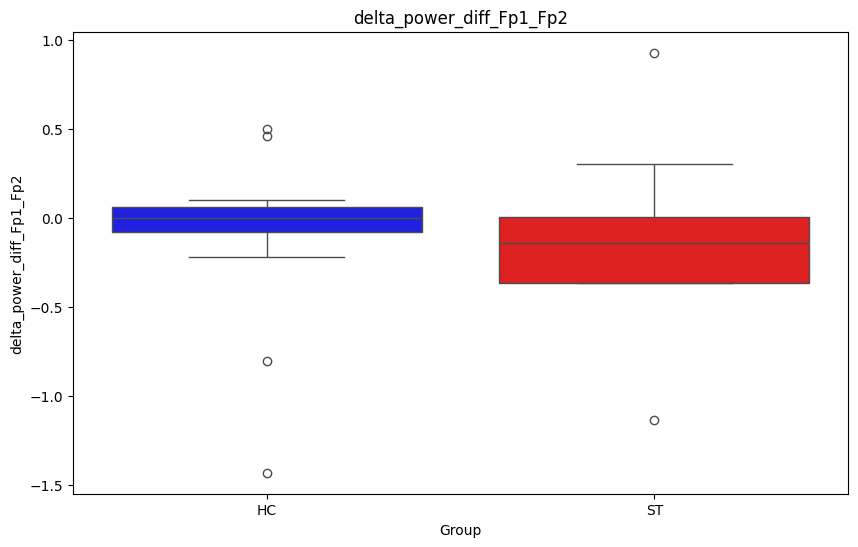

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


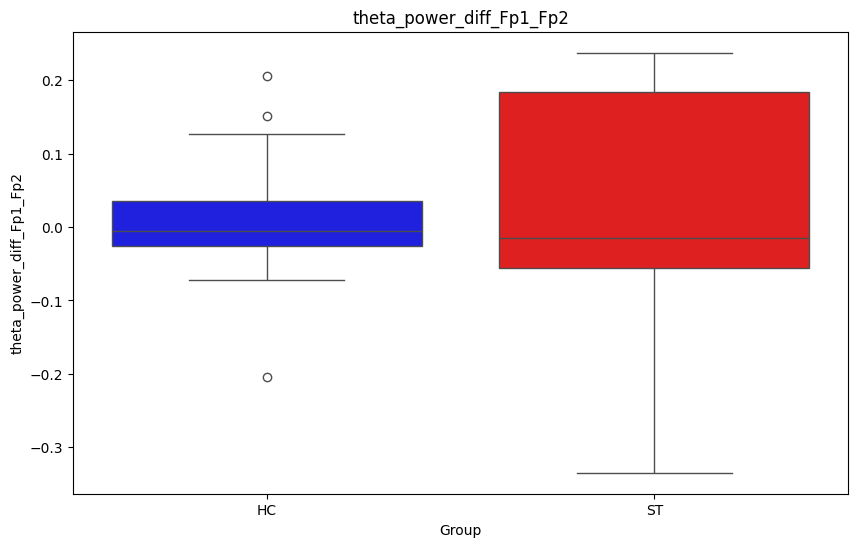

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


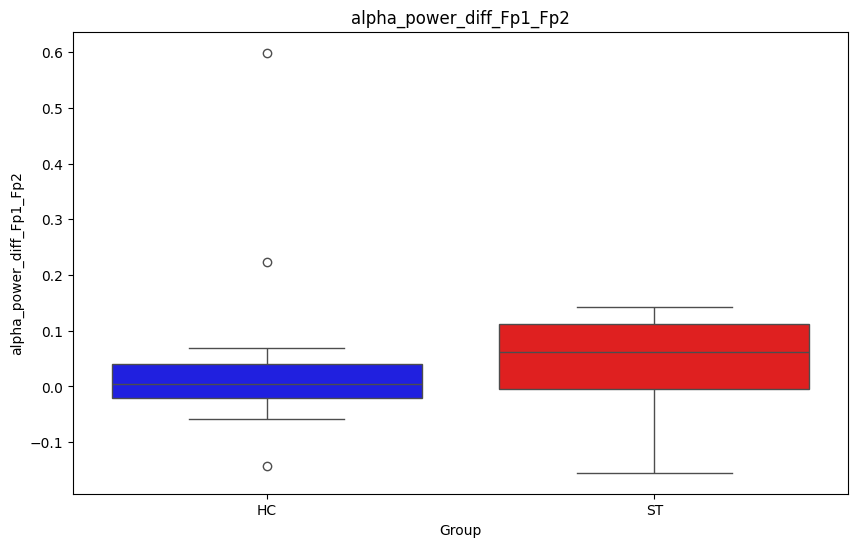

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


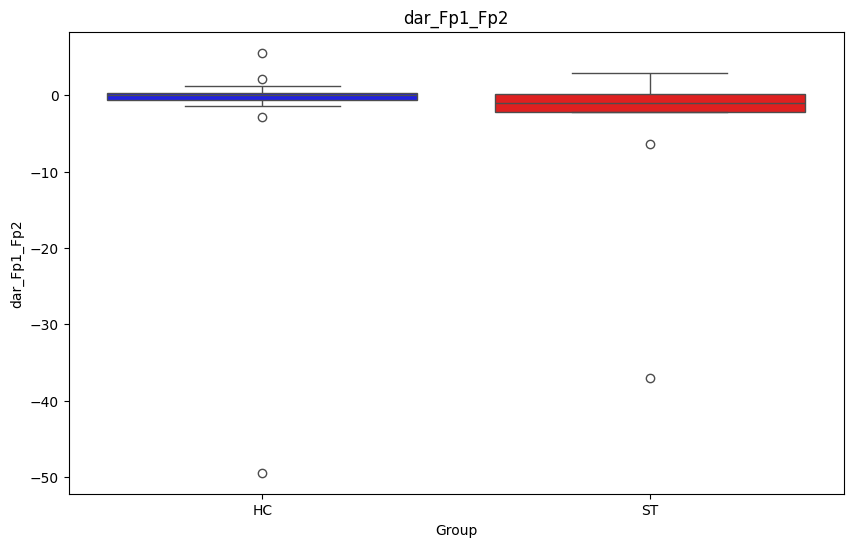

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


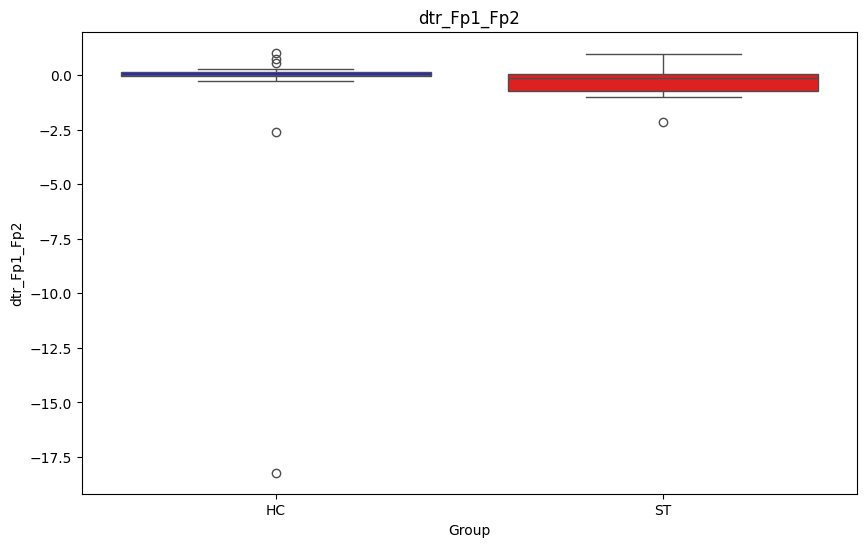

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


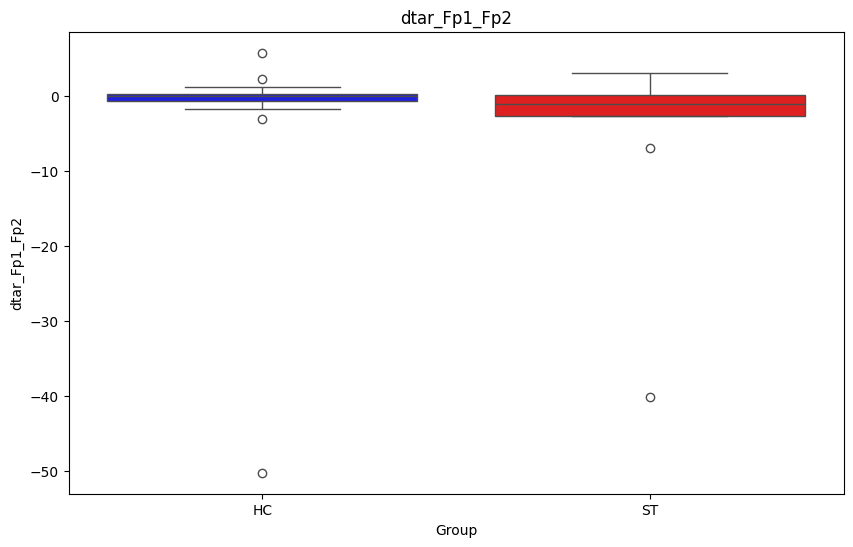

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


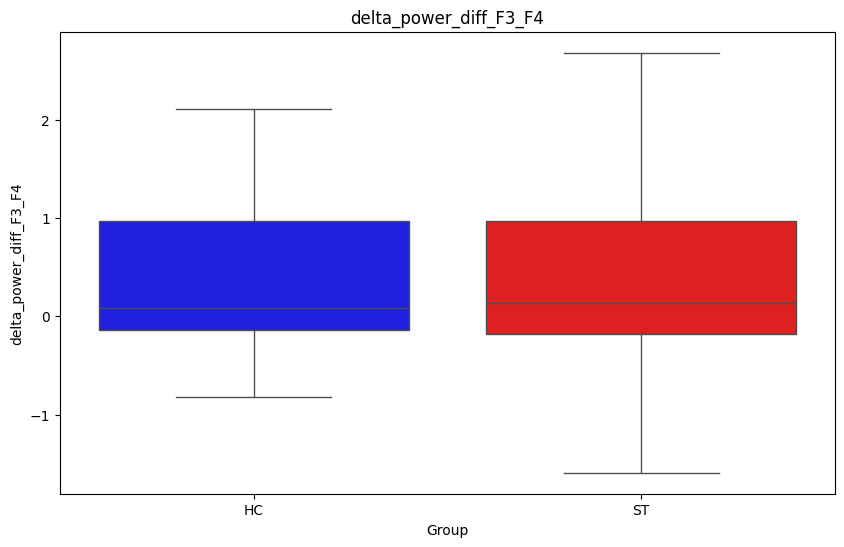

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


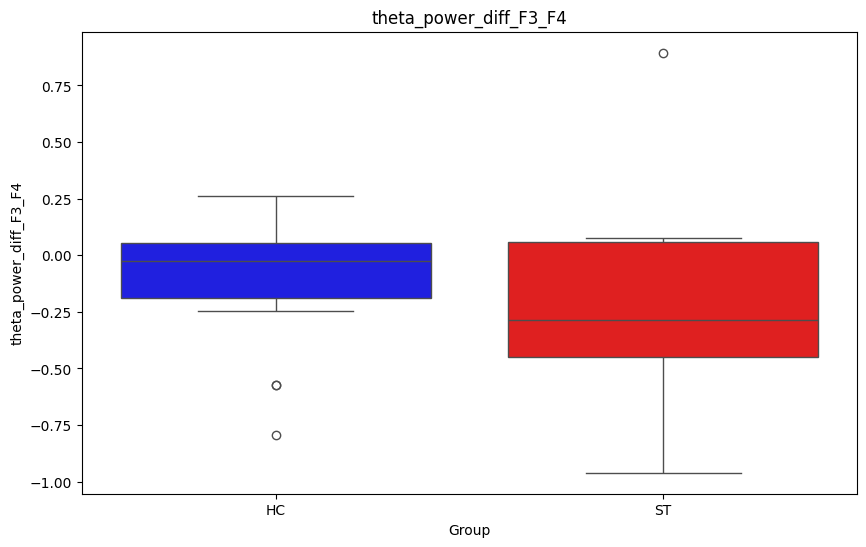

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


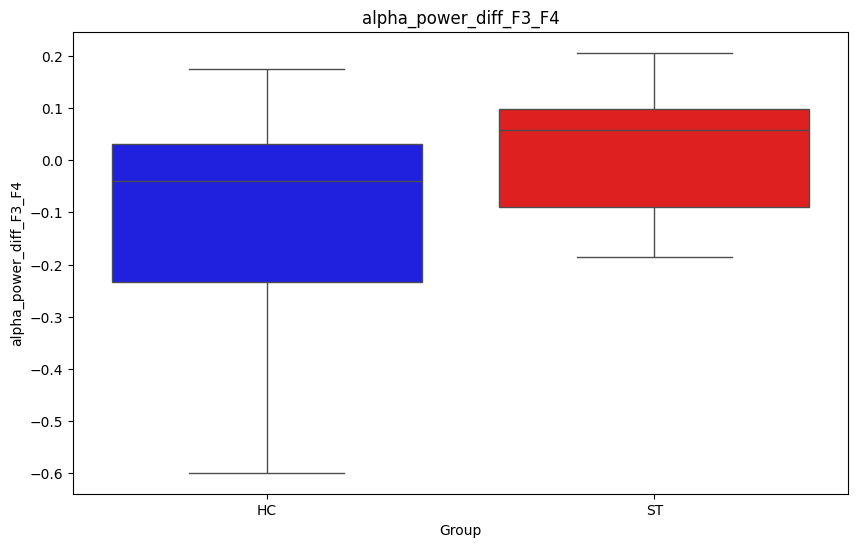

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


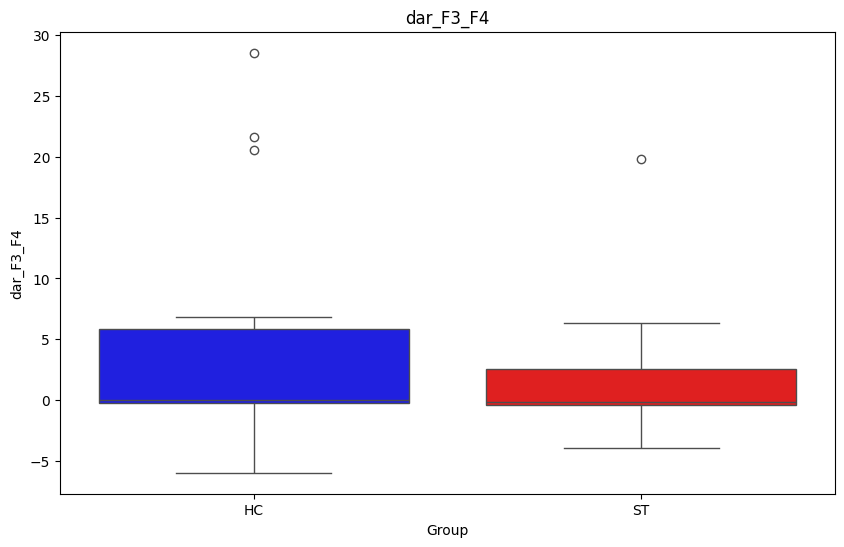

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


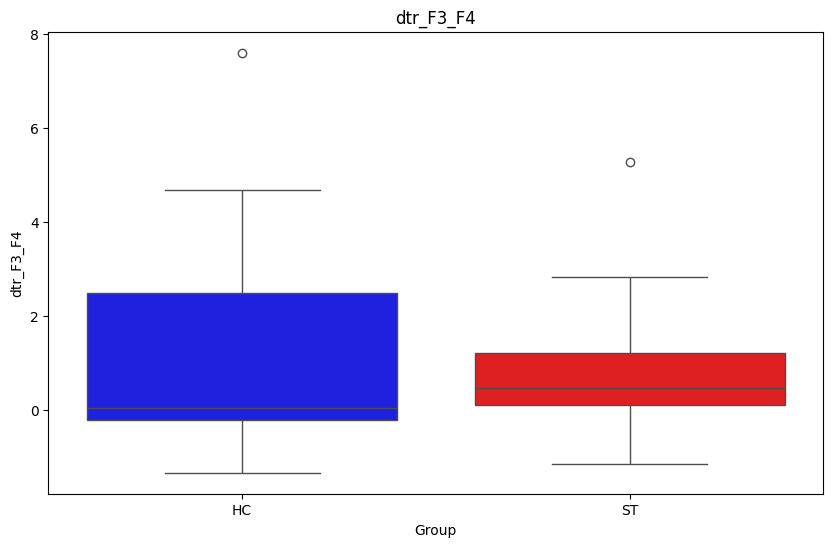

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


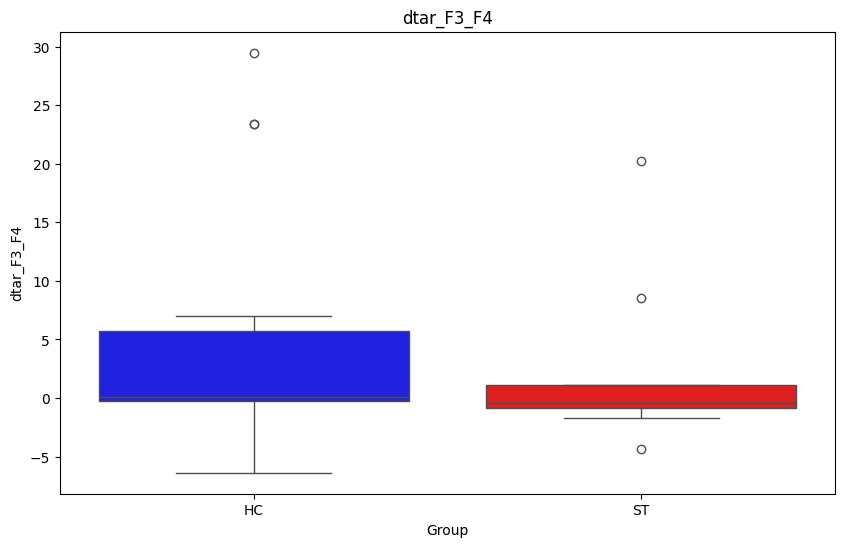

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


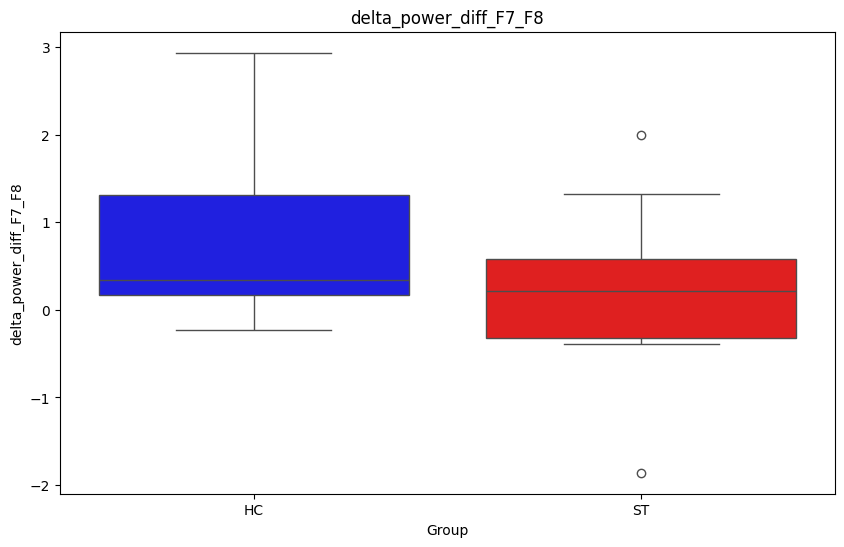

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


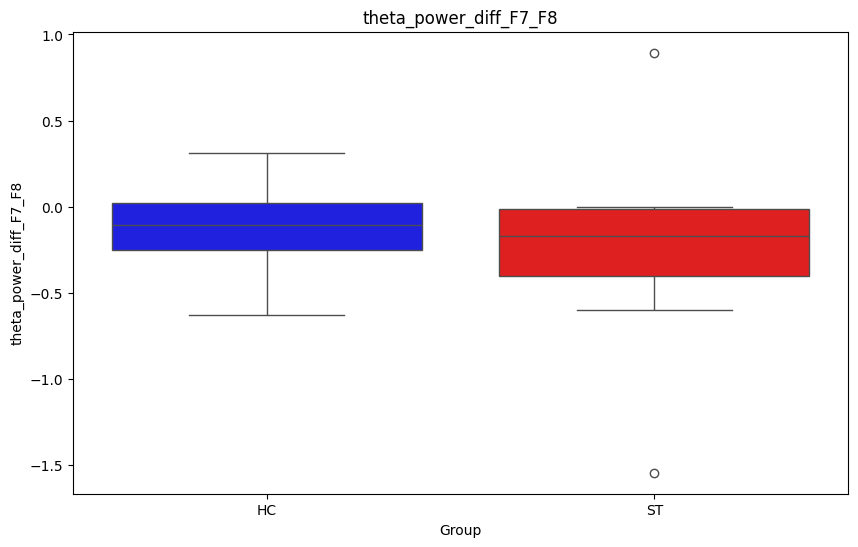

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


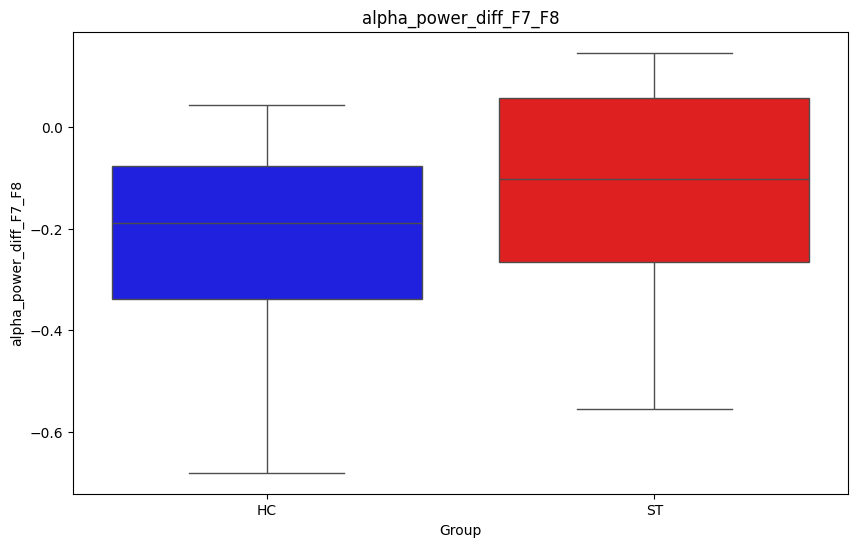

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


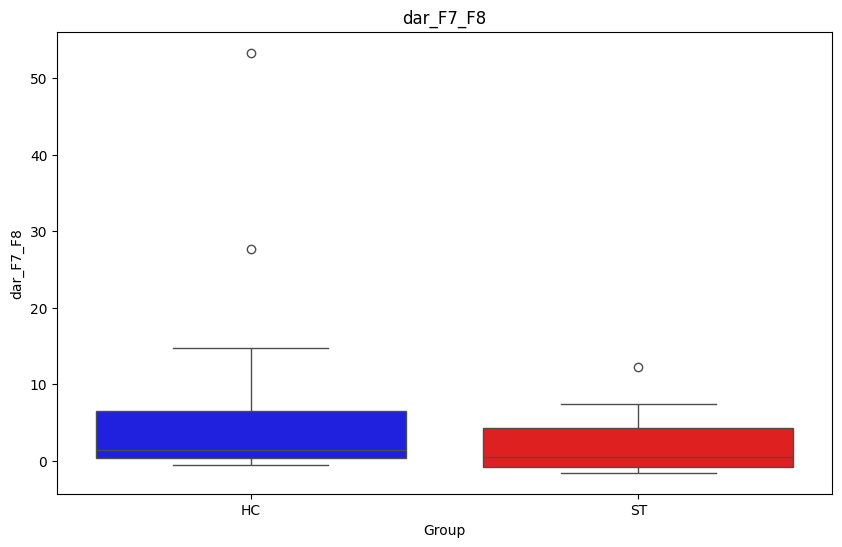

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


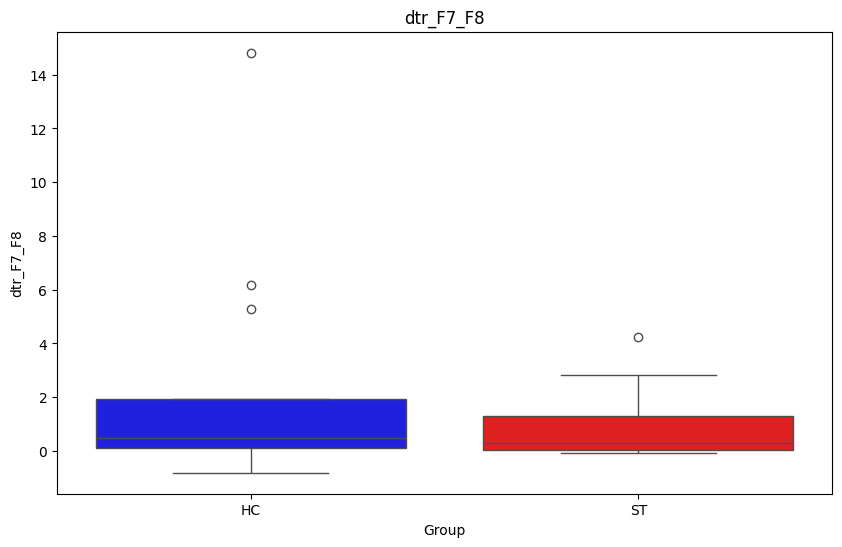

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


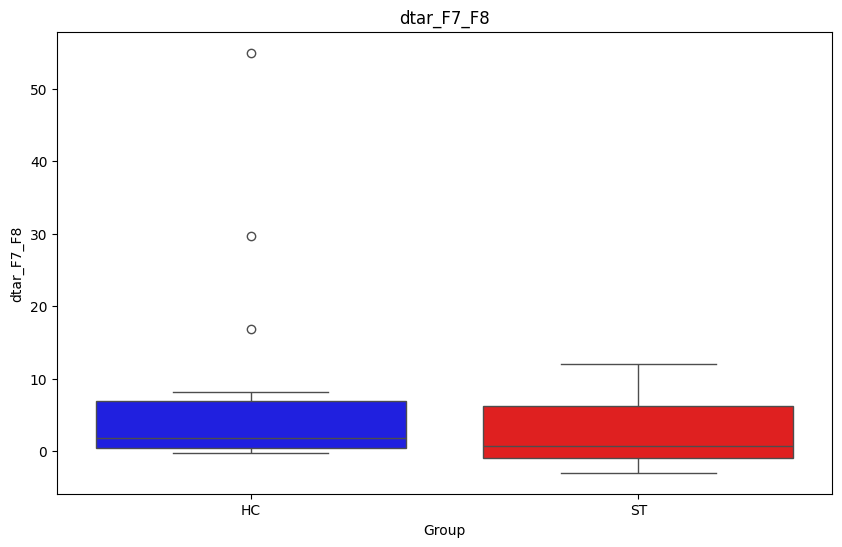

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


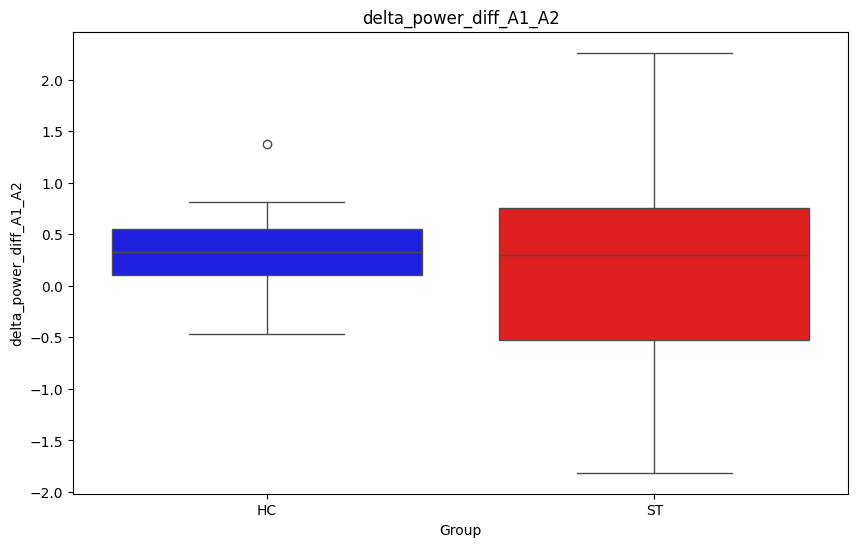

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


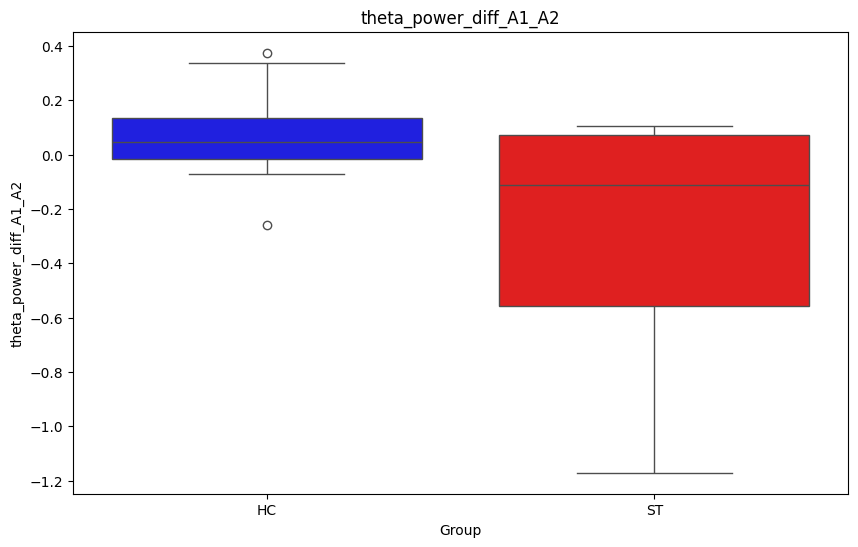

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


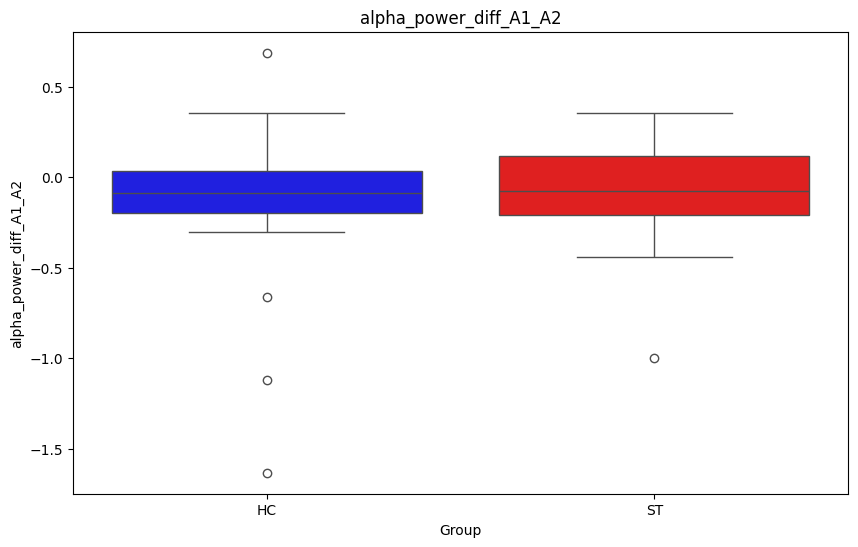

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


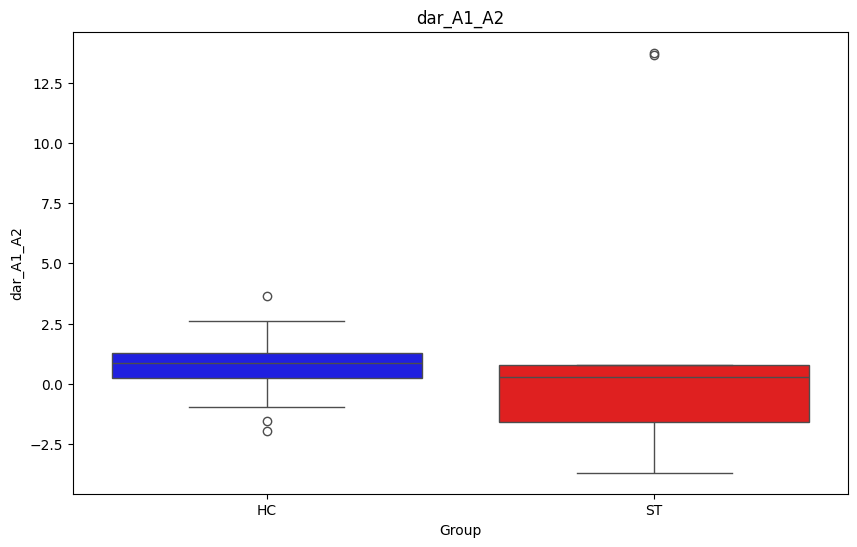

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


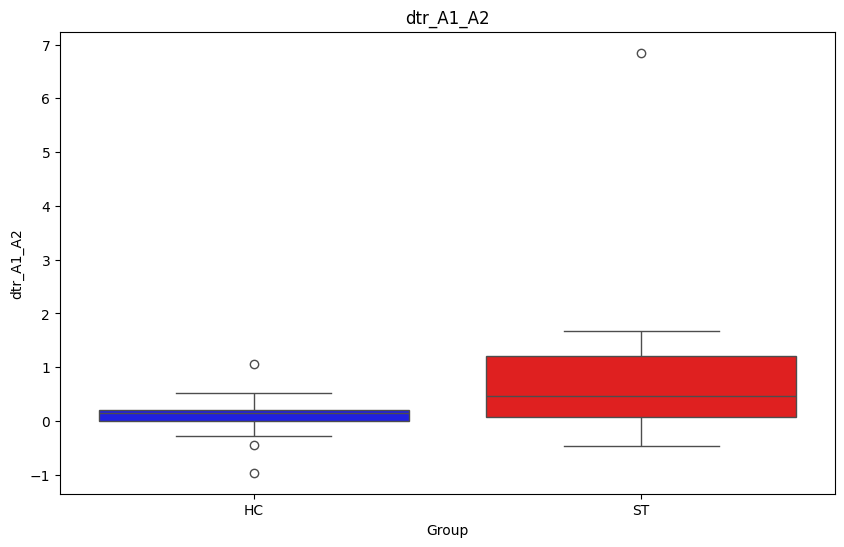

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


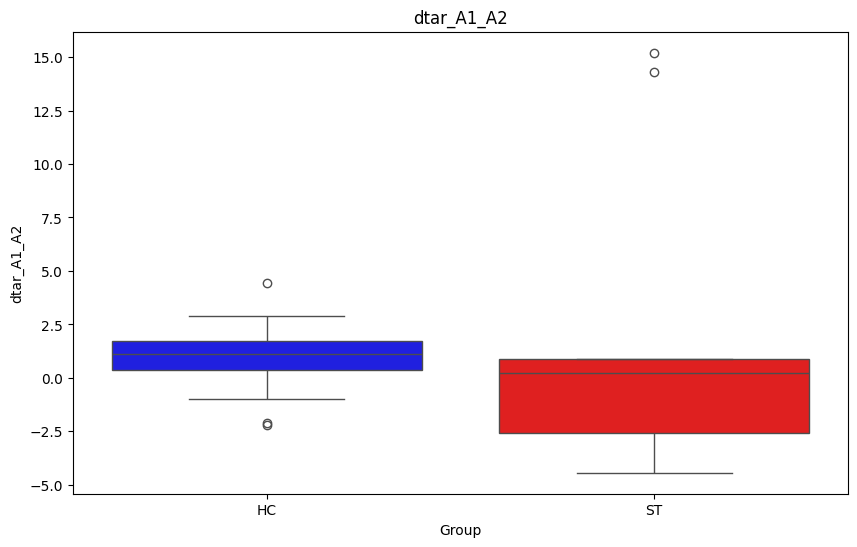

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


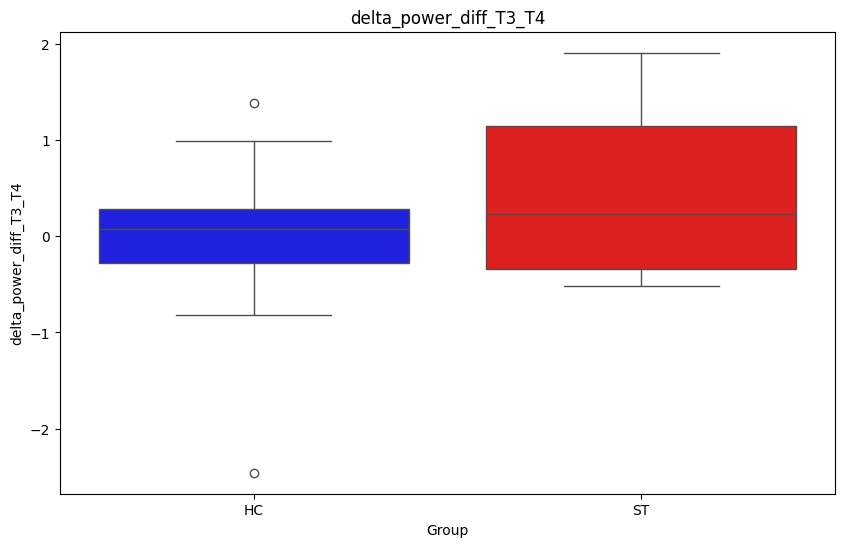

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


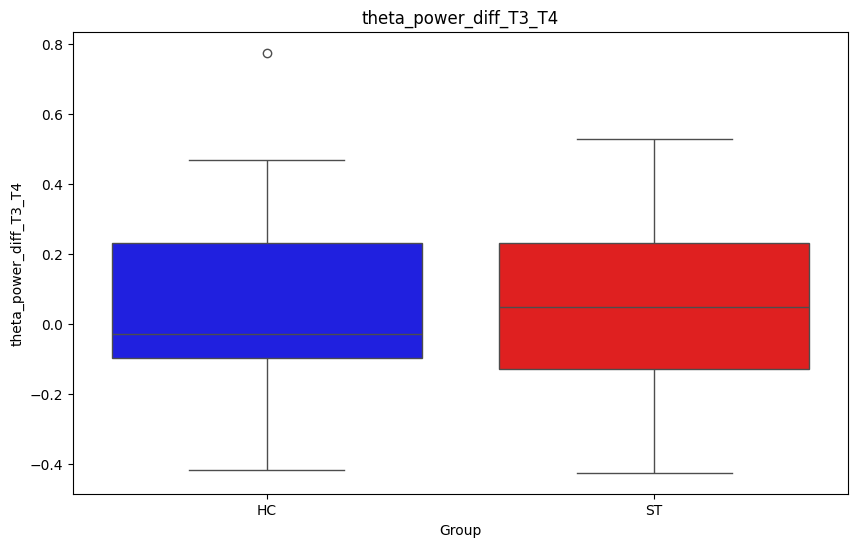

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


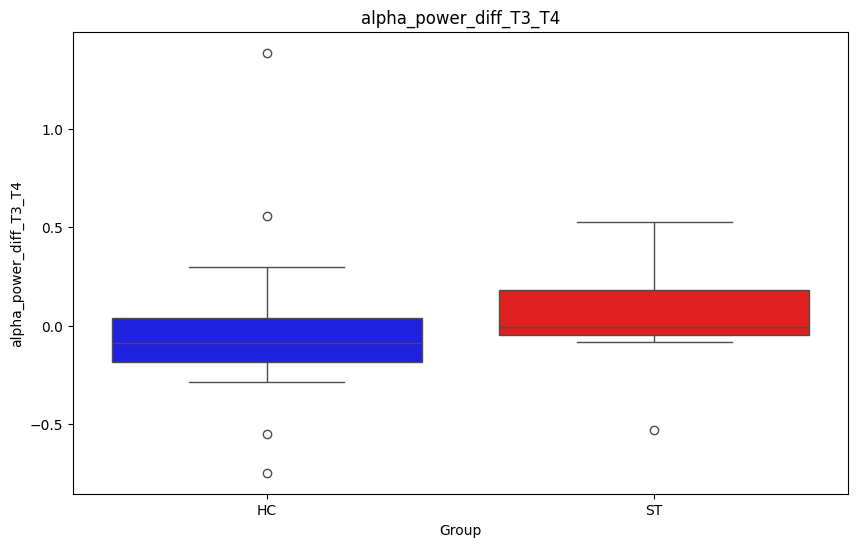

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


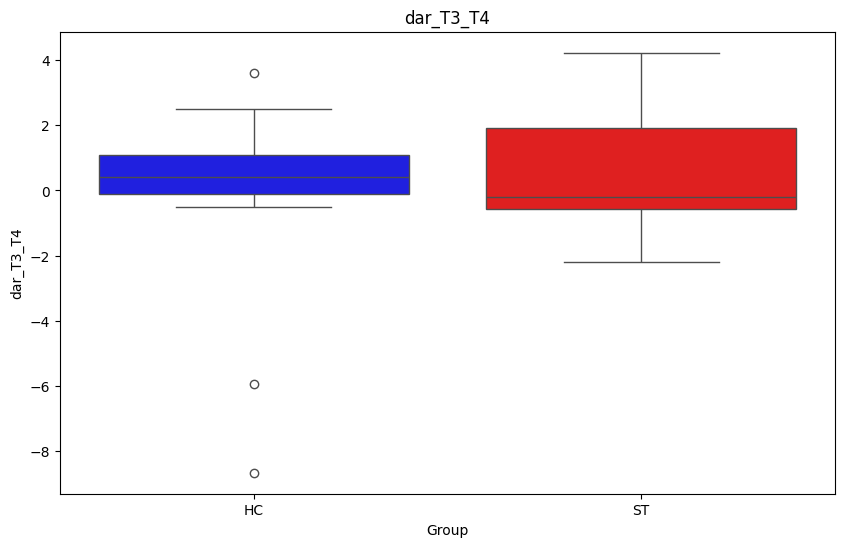

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


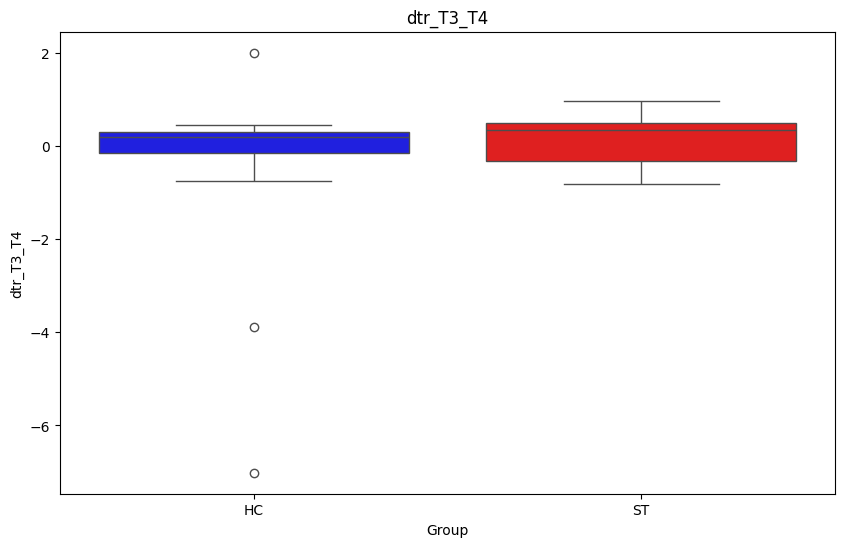

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


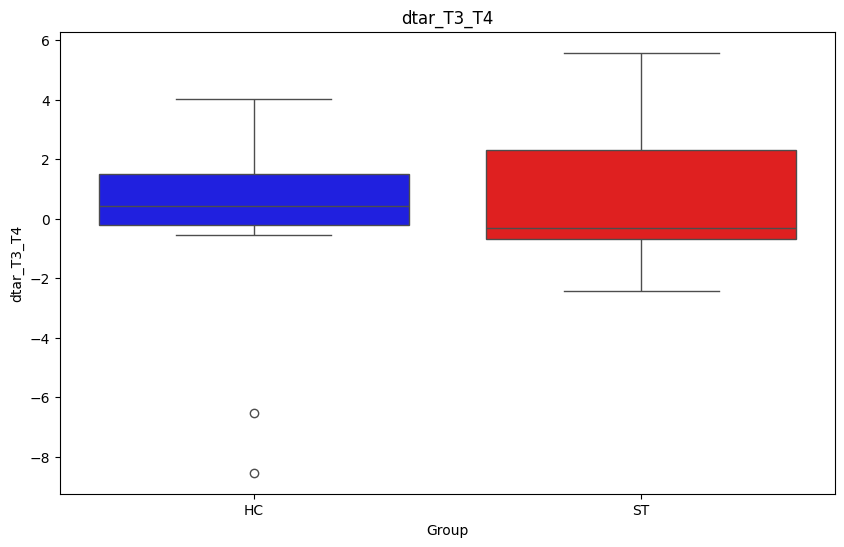

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


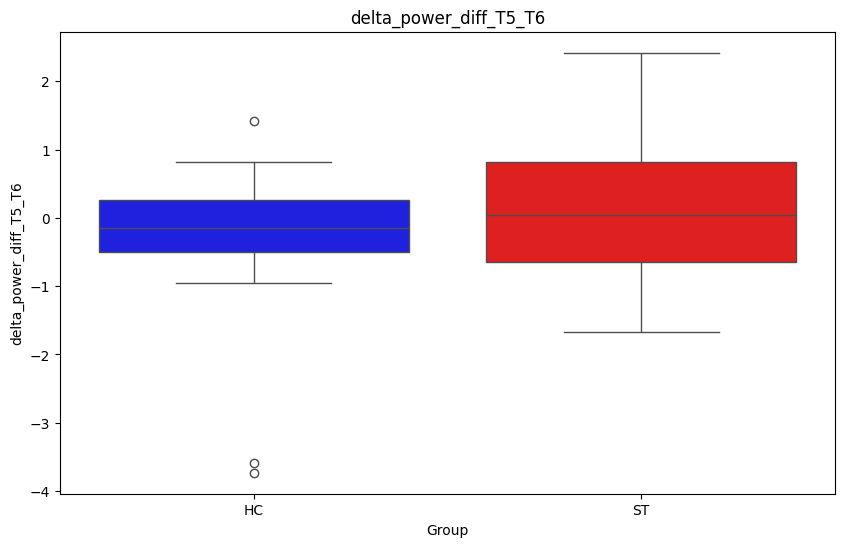

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


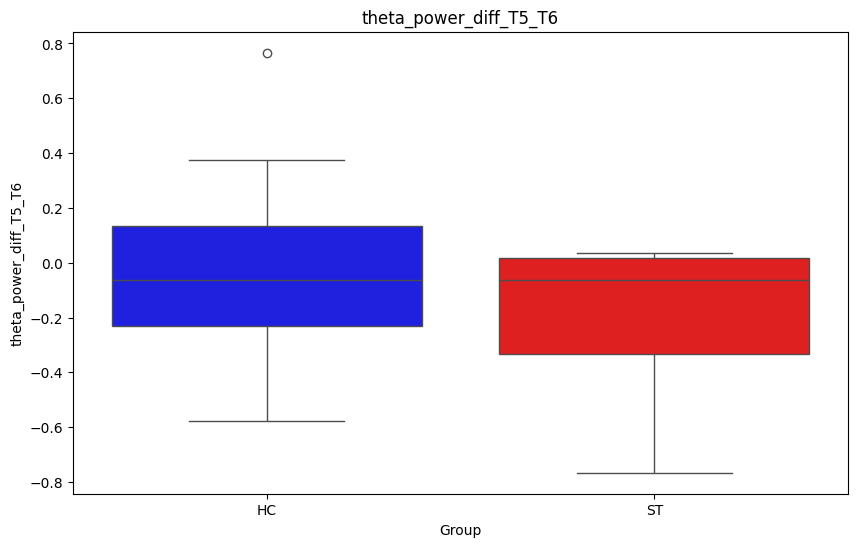

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


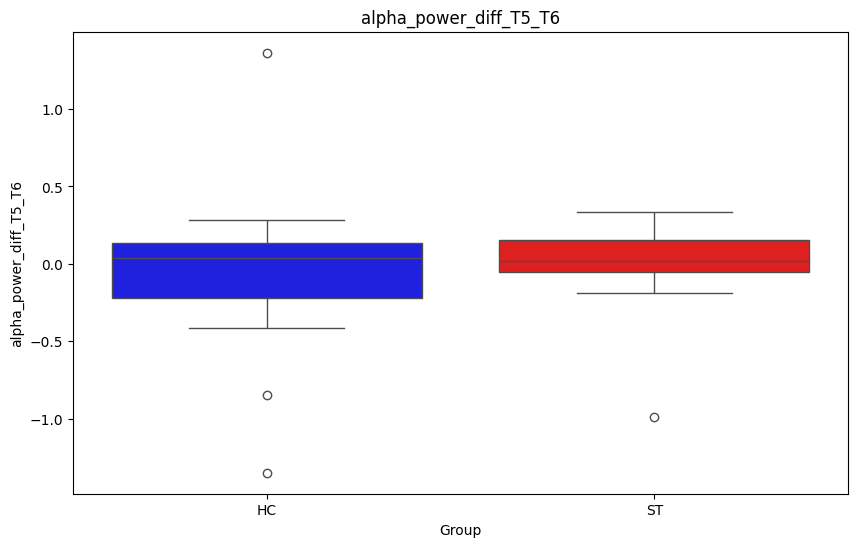

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


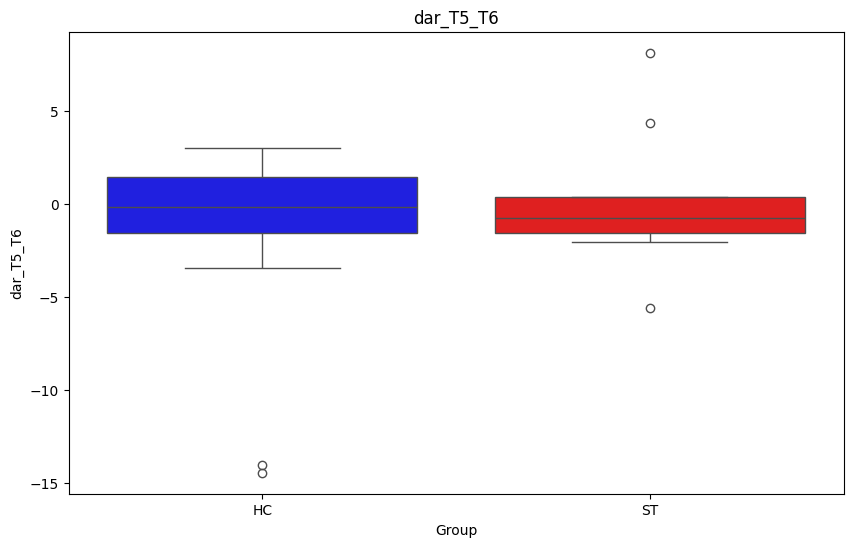

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


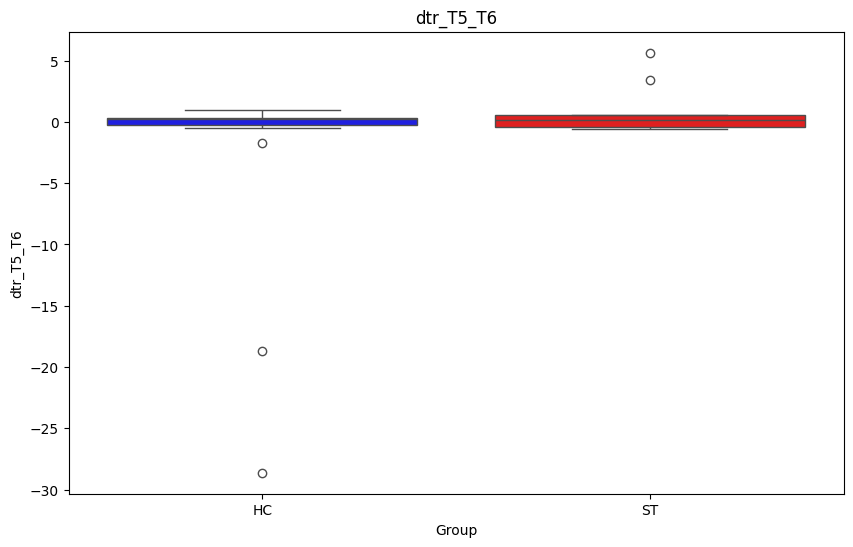

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


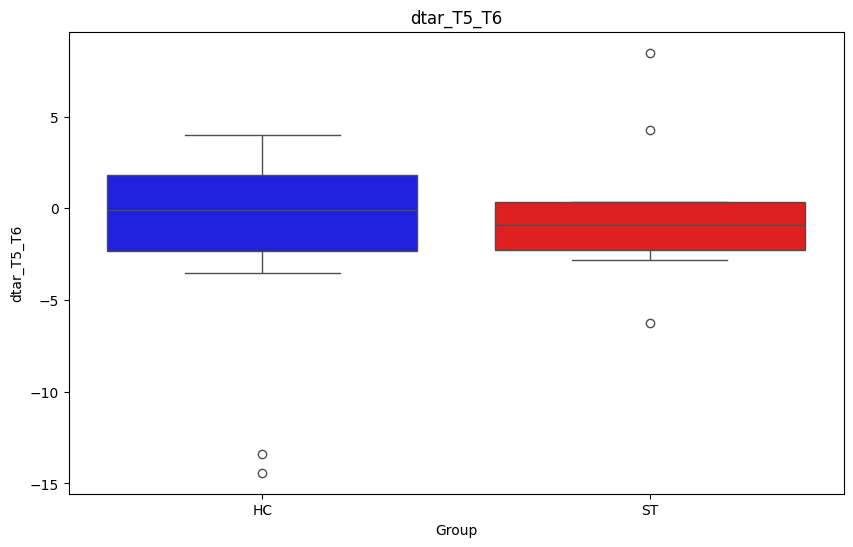

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


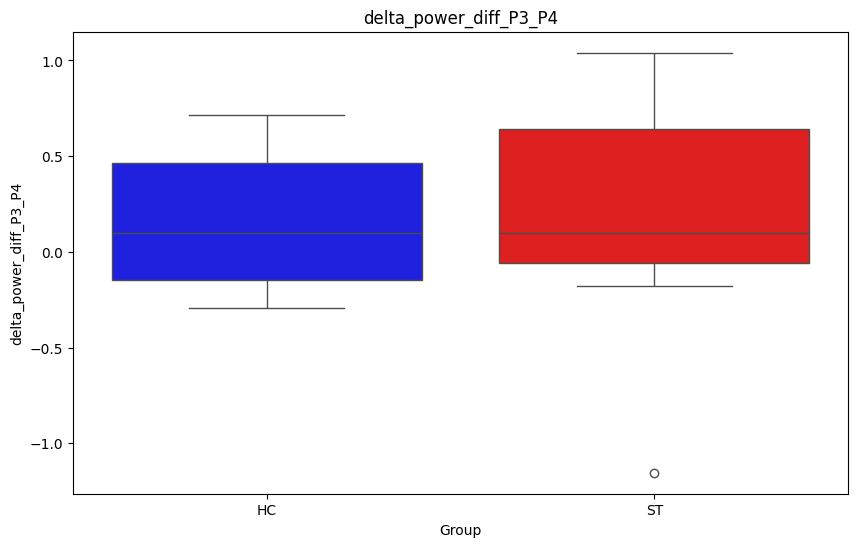

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


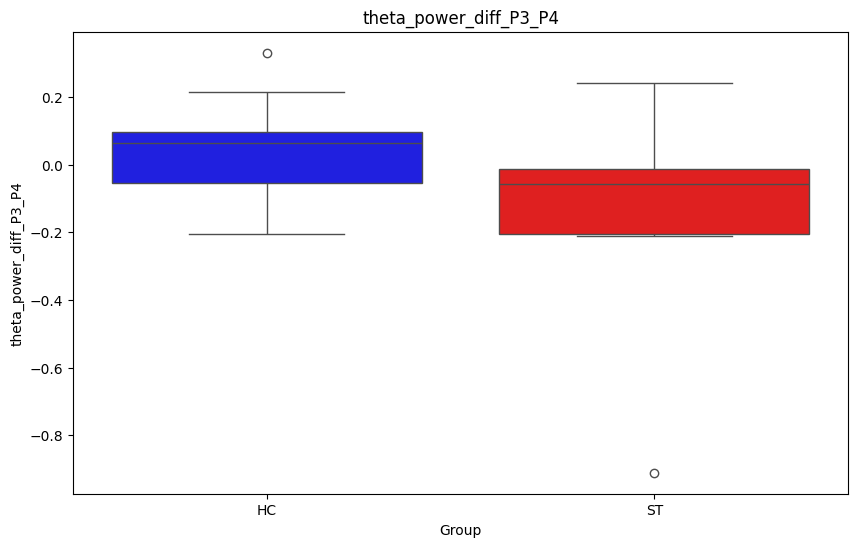

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


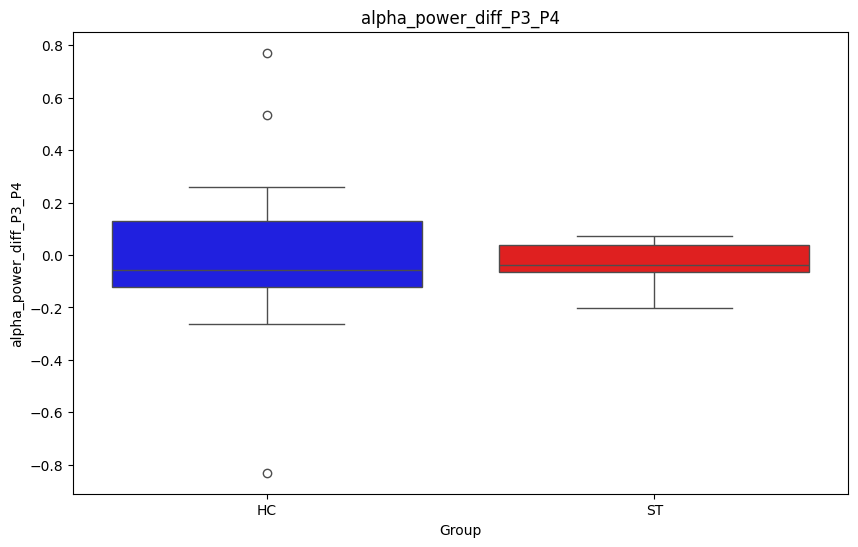

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


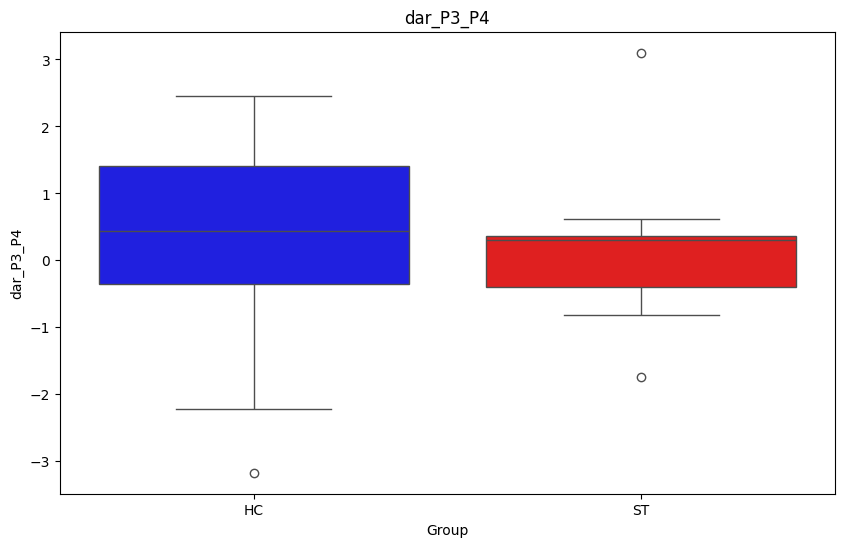

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


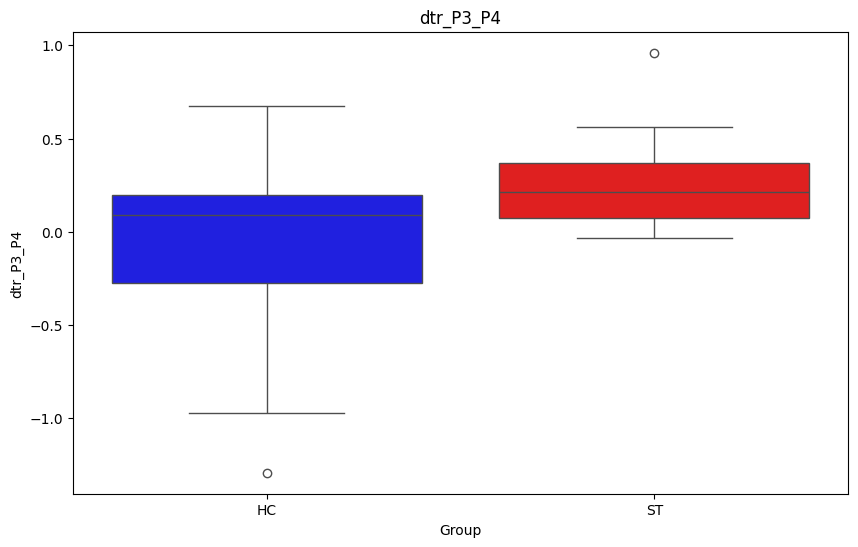

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


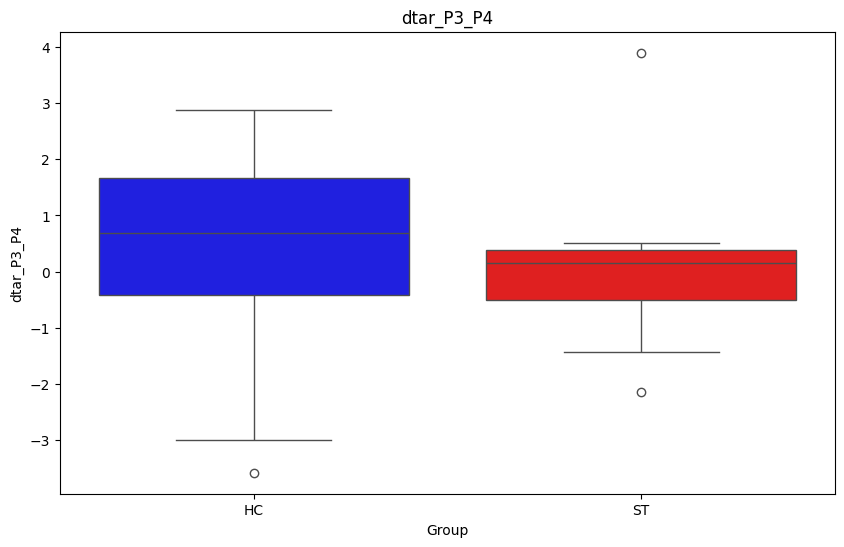

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


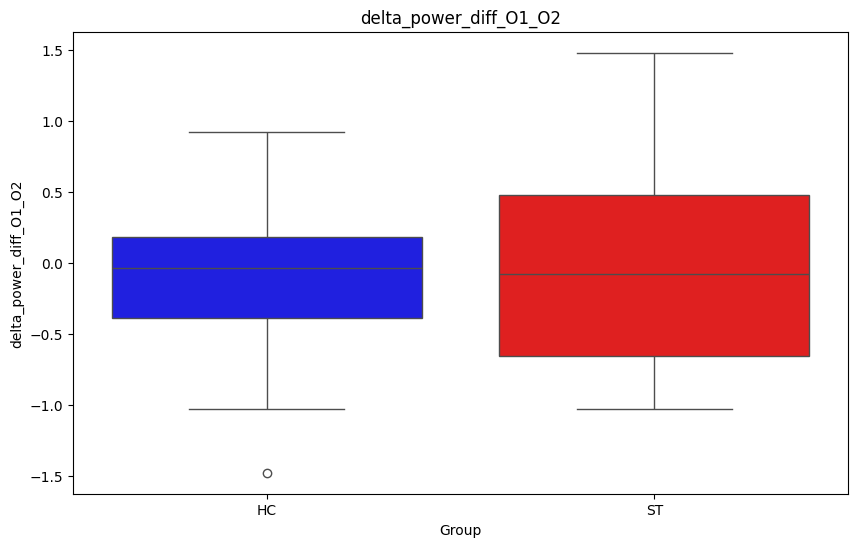

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


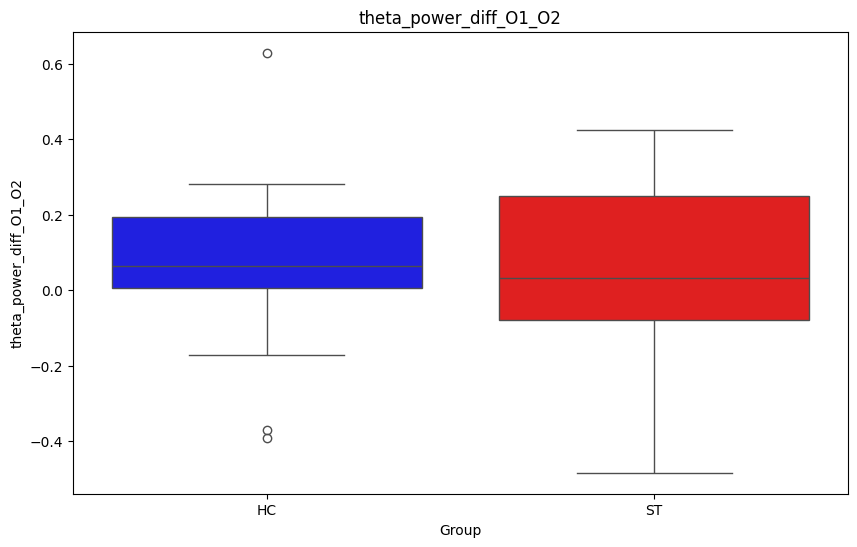

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


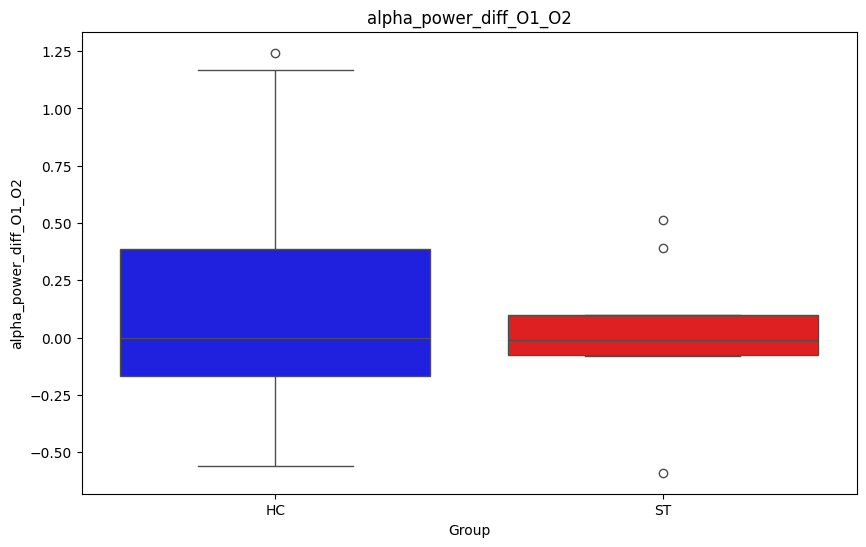

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


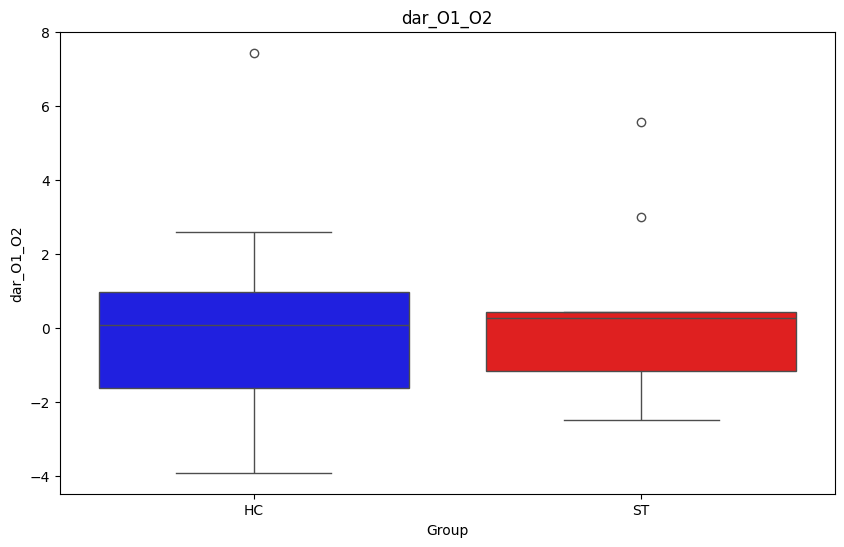

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


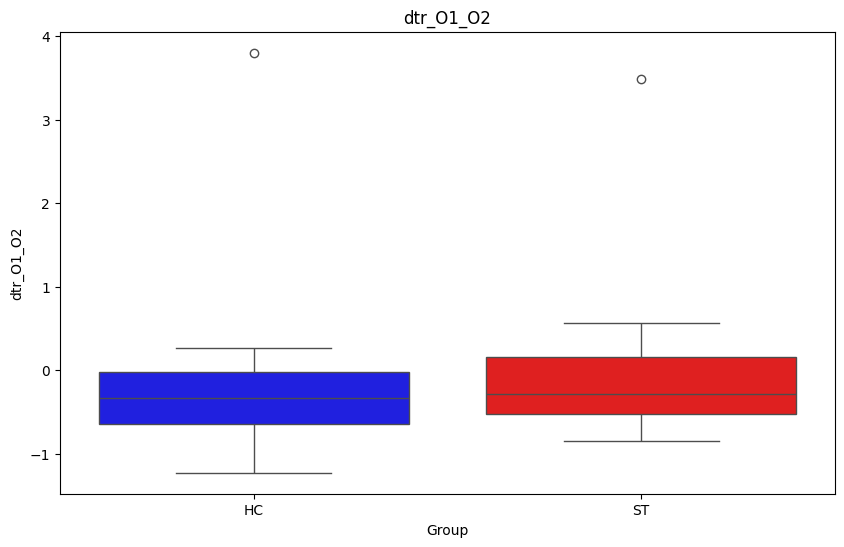

<ipython-input-16-c4346fb1241f>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)


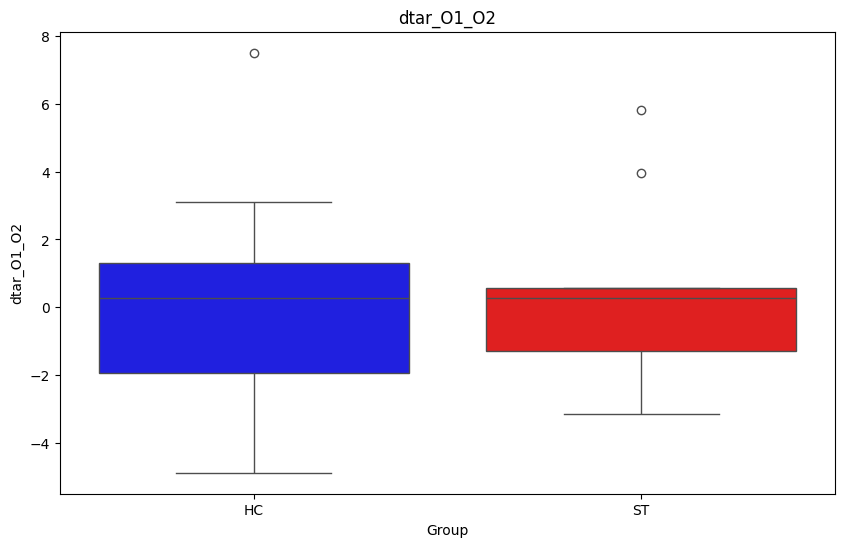

<ipython-input-16-c4346fb1241f>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette, ax=axes[i])
<ipython-input-16-c4346fb1241f>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette, ax=axes[i])
<ipython-input-16-c4346fb1241f>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette, ax=axes[i])
<ipython-input-16-c4346fb1241f>:41: FutureWarning: 

Passing `palette` without 

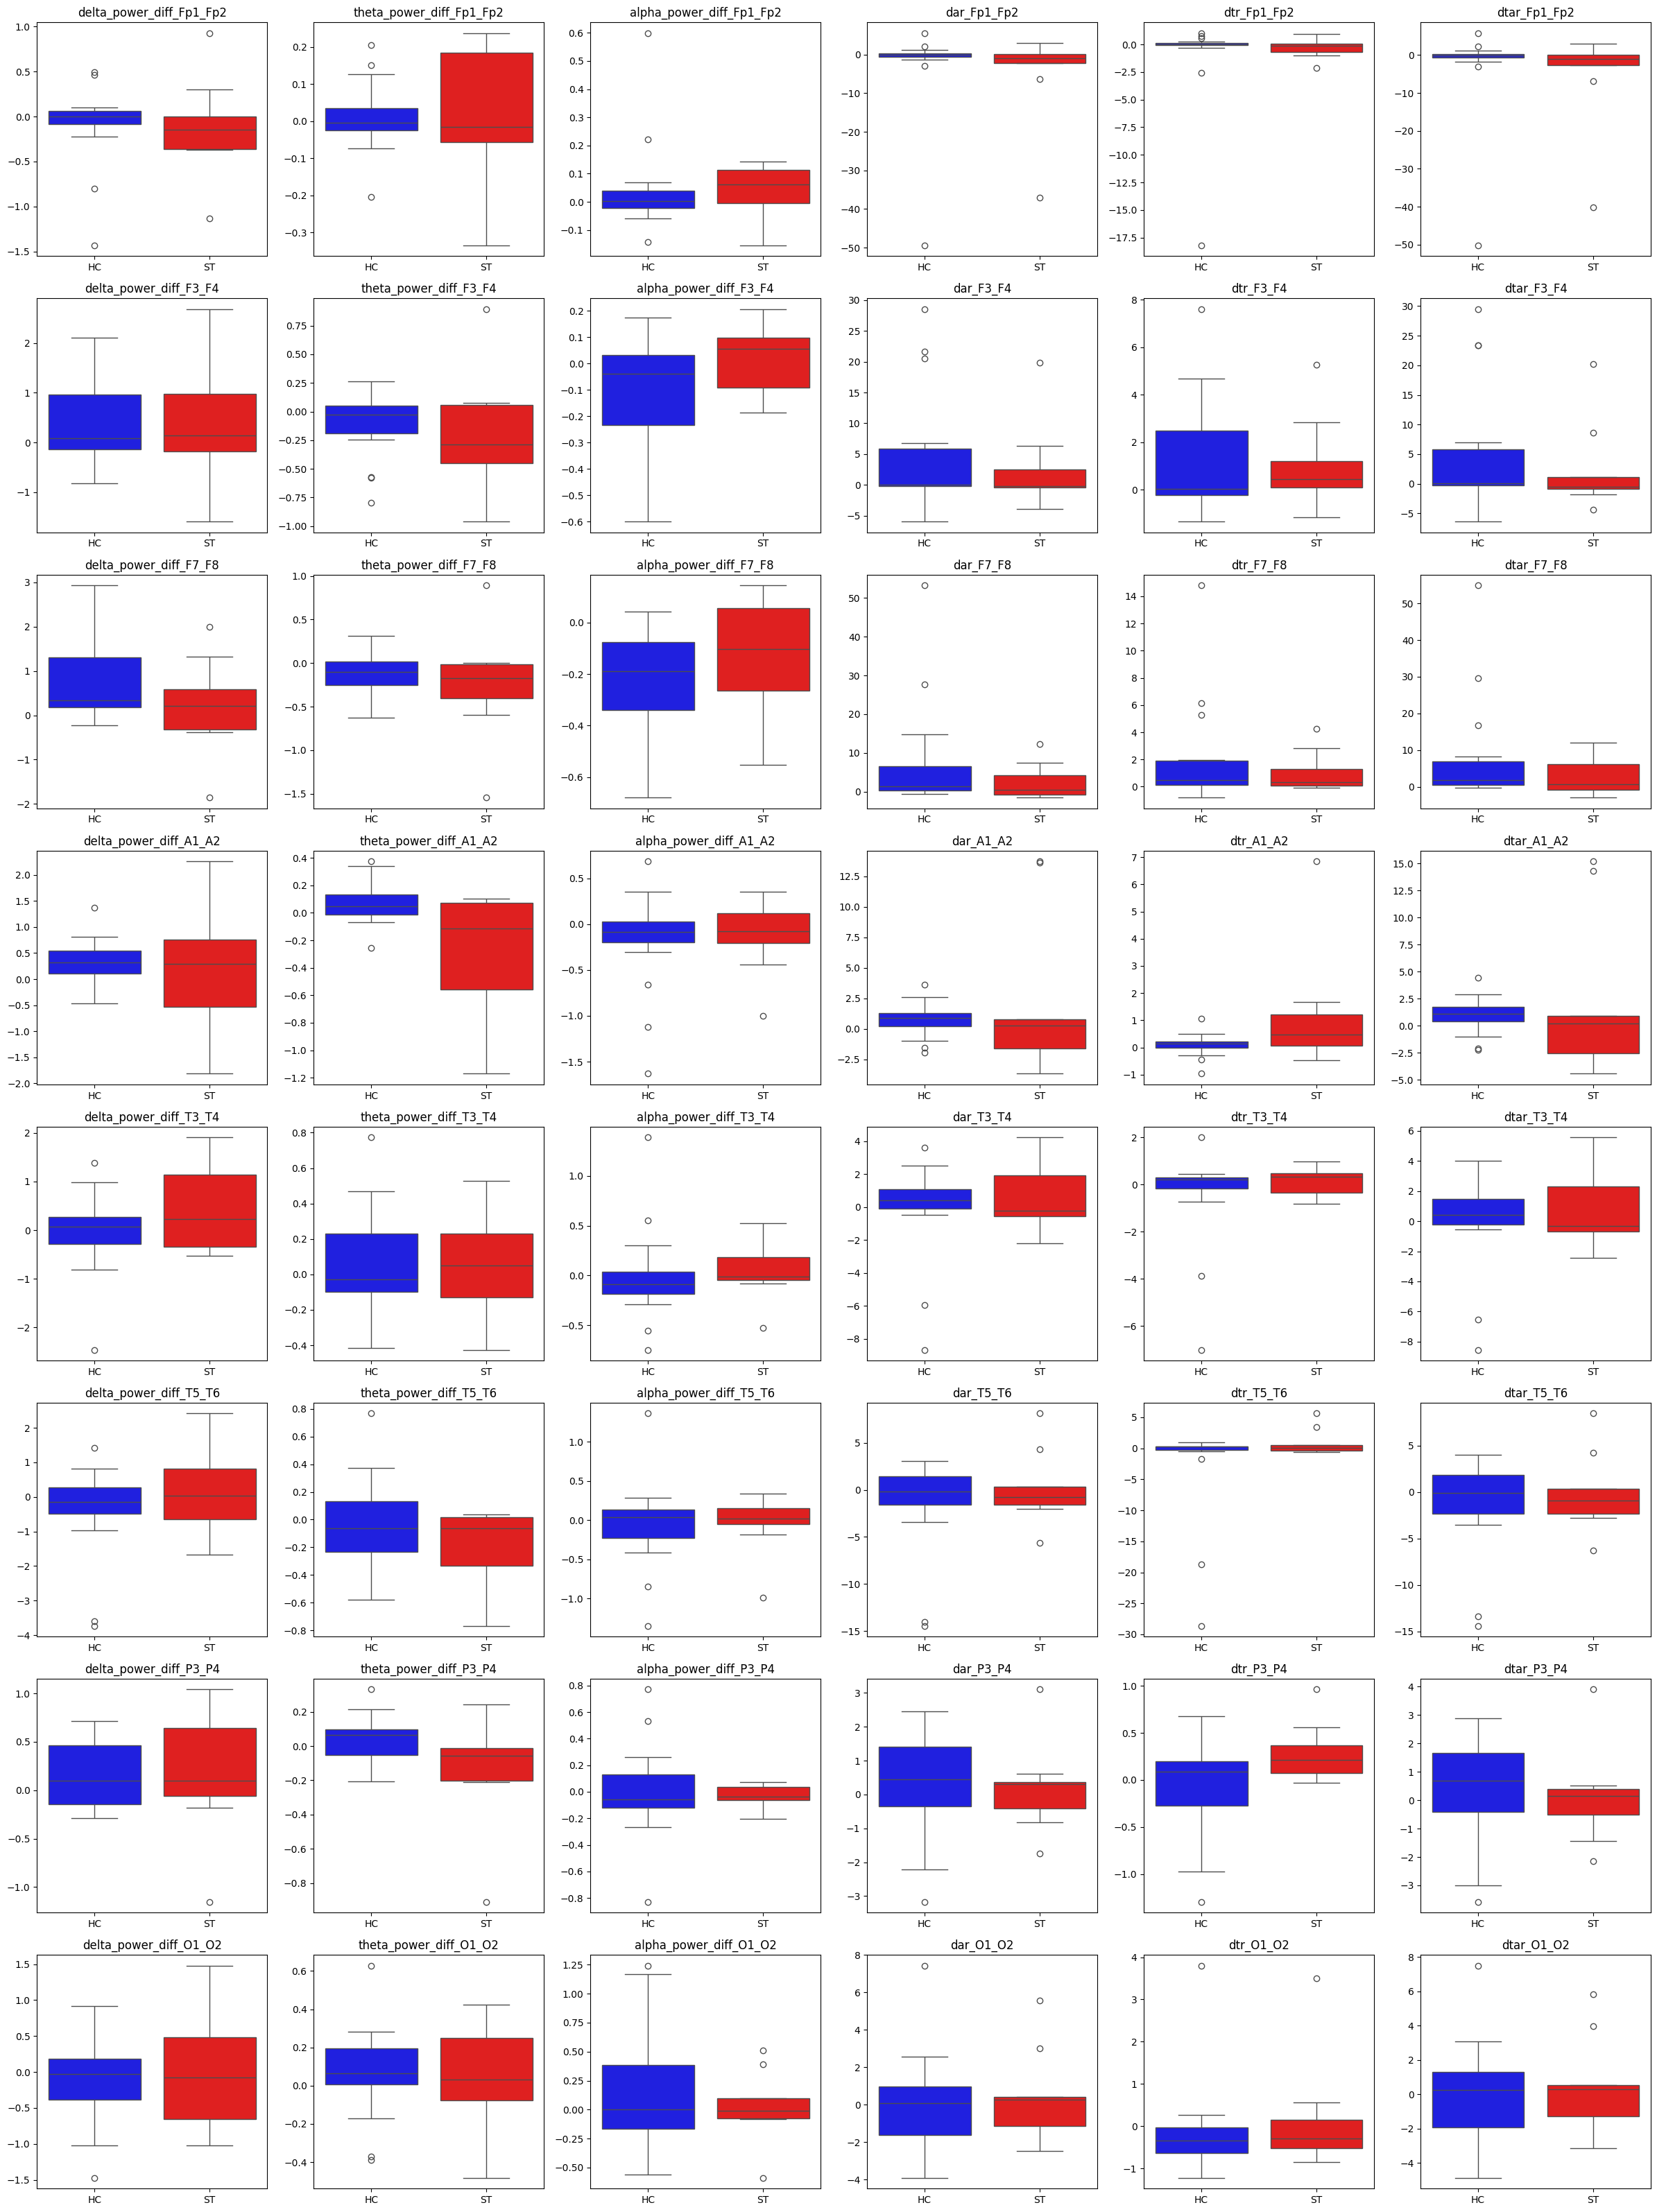

In [ ]:
# Assuming Data_Frame contains a 'Group' column indicating 'HC' and 'ST' groups
Data_Frame['Group_Label'] = Data_Frame['Group'].map({0: 'HC', 1: 'ST'})

features = [
    'delta_power_diff_Fp1_Fp2', 'theta_power_diff_Fp1_Fp2', 'alpha_power_diff_Fp1_Fp2',
    'dar_Fp1_Fp2', 'dtr_Fp1_Fp2', 'dtar_Fp1_Fp2',
    'delta_power_diff_F3_F4', 'theta_power_diff_F3_F4', 'alpha_power_diff_F3_F4',
    'dar_F3_F4', 'dtr_F3_F4', 'dtar_F3_F4',
    'delta_power_diff_F7_F8', 'theta_power_diff_F7_F8', 'alpha_power_diff_F7_F8',
    'dar_F7_F8', 'dtr_F7_F8', 'dtar_F7_F8',
    'delta_power_diff_A1_A2', 'theta_power_diff_A1_A2', 'alpha_power_diff_A1_A2',
    'dar_A1_A2', 'dtr_A1_A2', 'dtar_A1_A2',
    'delta_power_diff_T3_T4', 'theta_power_diff_T3_T4', 'alpha_power_diff_T3_T4',
    'dar_T3_T4', 'dtr_T3_T4', 'dtar_T3_T4',
    'delta_power_diff_T5_T6', 'theta_power_diff_T5_T6', 'alpha_power_diff_T5_T6',
    'dar_T5_T6', 'dtr_T5_T6', 'dtar_T5_T6',
    'delta_power_diff_P3_P4', 'theta_power_diff_P3_P4', 'alpha_power_diff_P3_P4',
    'dar_P3_P4', 'dtr_P3_P4', 'dtar_P3_P4',
    'delta_power_diff_O1_O2', 'theta_power_diff_O1_O2', 'alpha_power_diff_O1_O2',
    'dar_O1_O2', 'dtr_O1_O2', 'dtar_O1_O2'
]

palette = {'HC': 'blue', 'ST': 'red'}

# Plot boxplot of each feature for both groups
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette)
    plt.title(f'{feature}')
    plt.xlabel('Group')
    plt.ylabel(feature)
    plt.savefig(f'{feature}_boxplot.png')
    plt.show()

# Create a figure and a grid of subplots
fig, axes = plt.subplots(8, 6, figsize=(24, 32))
axes = axes.flatten()

# Plot each feature in the corresponding subplot
for i, feature in enumerate(features):
    sns.boxplot(data=Data_Frame, x='Group_Label', y=feature, palette=palette, ax=axes[i])
    axes[i].set_title(f'{feature}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.savefig('all_features_boxplot.png')
plt.show()

# P-value

In [ ]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Assuming Data_Frame contains the features and a 'Group' column
features = [
    'delta_power_diff_Fp1_Fp2', 'theta_power_diff_Fp1_Fp2', 'alpha_power_diff_Fp1_Fp2',
    'dar_Fp1_Fp2', 'dtr_Fp1_Fp2', 'dtar_Fp1_Fp2',
    'delta_power_diff_F3_F4', 'theta_power_diff_F3_F4', 'alpha_power_diff_F3_F4',
    'dar_F3_F4', 'dtr_F3_F4', 'dtar_F3_F4',
    'delta_power_diff_F7_F8', 'theta_power_diff_F7_F8', 'alpha_power_diff_F7_F8',
    'dar_F7_F8', 'dtr_F7_F8', 'dtar_F7_F8',
    'delta_power_diff_A1_A2', 'theta_power_diff_A1_A2', 'alpha_power_diff_A1_A2',
    'dar_A1_A2', 'dtr_A1_A2', 'dtar_A1_A2',
    'delta_power_diff_T3_T4', 'theta_power_diff_T3_T4', 'alpha_power_diff_T3_T4',
    'dar_T3_T4', 'dtr_T3_T4', 'dtar_T3_T4',
    'delta_power_diff_T5_T6', 'theta_power_diff_T5_T6', 'alpha_power_diff_T5_T6',
    'dar_T5_T6', 'dtr_T5_T6', 'dtar_T5_T6',
    'delta_power_diff_P3_P4', 'theta_power_diff_P3_P4', 'alpha_power_diff_P3_P4',
    'dar_P3_P4', 'dtr_P3_P4', 'dtar_P3_P4',
    'delta_power_diff_O1_O2', 'theta_power_diff_O1_O2', 'alpha_power_diff_O1_O2',
    'dar_O1_O2', 'dtr_O1_O2', 'dtar_O1_O2'
]

# Split the data into two groups
group_HC = Data_Frame[Data_Frame['Group'] == 0]
group_ST = Data_Frame[Data_Frame['Group'] == 1]

# Calculate mean, standard deviation, and p-values for each feature
results = []

for feature in features:
    hc_mean = group_HC[feature].mean()
    hc_std = group_HC[feature].std()
    st_mean = group_ST[feature].mean()
    st_std = group_ST[feature].std()
    stat, p_value = mannwhitneyu(group_HC[feature], group_ST[feature], alternative='two-sided')
    results.append({
        'Feature': feature,
        'HC Mean (±SD)': f'{hc_mean:.2f} (±{hc_std:.2f})',
        'ST Mean (±SD)': f'{st_mean:.2f} (±{st_std:.2f})',
        'p-value': f'{p_value:.3e}'
    })

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

# Mark significance levels
def annotate_p_value(row):
    p = float(row['p-value'])
    if p < 0.001:
        return '<0.001***'
    elif p < 0.01:
        return f'{p:.3f}**'
    elif p < 0.05:
        return f'{p:.3f}*'
    else:
        return f'{p:.3f}'

results_df['p-value'] = results_df.apply(annotate_p_value, axis=1)

# Print the results
print(results_df)

# Save the results to a CSV file
results_df.to_csv('feature_statistics.csv', index=False)


                     Feature   HC Mean (±SD)   ST Mean (±SD) p-value
0   delta_power_diff_Fp1_Fp2   -0.09 (±0.46)   -0.13 (±0.56)   0.322
1   theta_power_diff_Fp1_Fp2    0.01 (±0.09)    0.02 (±0.18)   0.713
2   alpha_power_diff_Fp1_Fp2    0.04 (±0.17)    0.04 (±0.10)   0.591
3                dar_Fp1_Fp2  -2.88 (±12.54)  -4.84 (±12.36)   0.322
4                dtr_Fp1_Fp2   -1.15 (±4.62)   -0.31 (±0.92)   0.380
5               dtar_Fp1_Fp2  -2.95 (±12.74)  -5.26 (±13.40)   0.322
6     delta_power_diff_F3_F4    0.35 (±0.85)    0.33 (±1.24)   0.977
7     theta_power_diff_F3_F4   -0.12 (±0.29)   -0.22 (±0.57)   0.479
8     alpha_power_diff_F3_F4   -0.12 (±0.22)    0.01 (±0.13)   0.149
9                  dar_F3_F4    4.82 (±9.84)    2.55 (±7.05)   0.350
10                 dtr_F3_F4    1.15 (±2.47)    1.06 (±1.91)   0.380
11                dtar_F3_F4   5.19 (±10.51)    2.42 (±7.55)   0.224
12    delta_power_diff_F7_F8    0.74 (±0.93)    0.23 (±1.10)   0.350
13    theta_power_diff_F7_F8   -0.

###PCA Plot

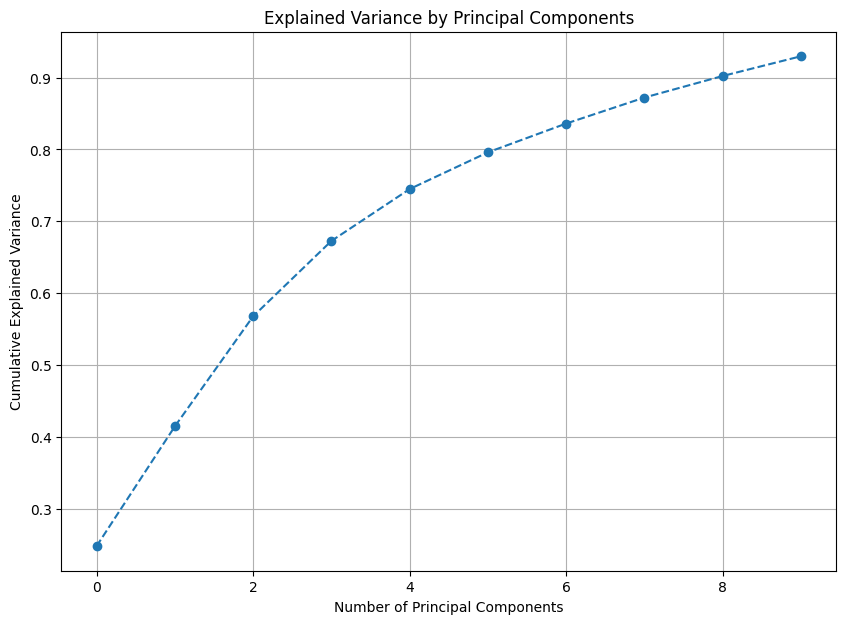

                               PC1       PC2       PC3       PC4       PC5  \
delta_power_diff_Fp1_Fp2 -0.079715 -0.792909 -0.434297 -0.205282 -0.079343   
theta_power_diff_Fp1_Fp2  0.199797  0.601972  0.373683 -0.332571  0.097742   
alpha_power_diff_Fp1_Fp2  0.099598  0.898816  0.050857  0.083159  0.006275   
dar_Fp1_Fp2              -0.545019 -0.231818 -0.542039 -0.433172 -0.108788   
dtr_Fp1_Fp2              -0.786617 -0.335564 -0.215300 -0.204312 -0.181994   
dtar_Fp1_Fp2             -0.521657 -0.230346 -0.556789 -0.443659 -0.105001   
delta_power_diff_F3_F4    0.523082 -0.165057  0.082864 -0.735979 -0.124542   
theta_power_diff_F3_F4   -0.266865  0.389682  0.371561 -0.268506  0.596241   
alpha_power_diff_F3_F4   -0.587537  0.342017 -0.036651  0.321178  0.387926   
dar_F3_F4                 0.888624 -0.030113  0.169055 -0.164273 -0.281239   
dtr_F3_F4                 0.912323 -0.200055  0.082421 -0.090534 -0.227113   
dtar_F3_F4                0.869267 -0.021397  0.186507 -0.199589

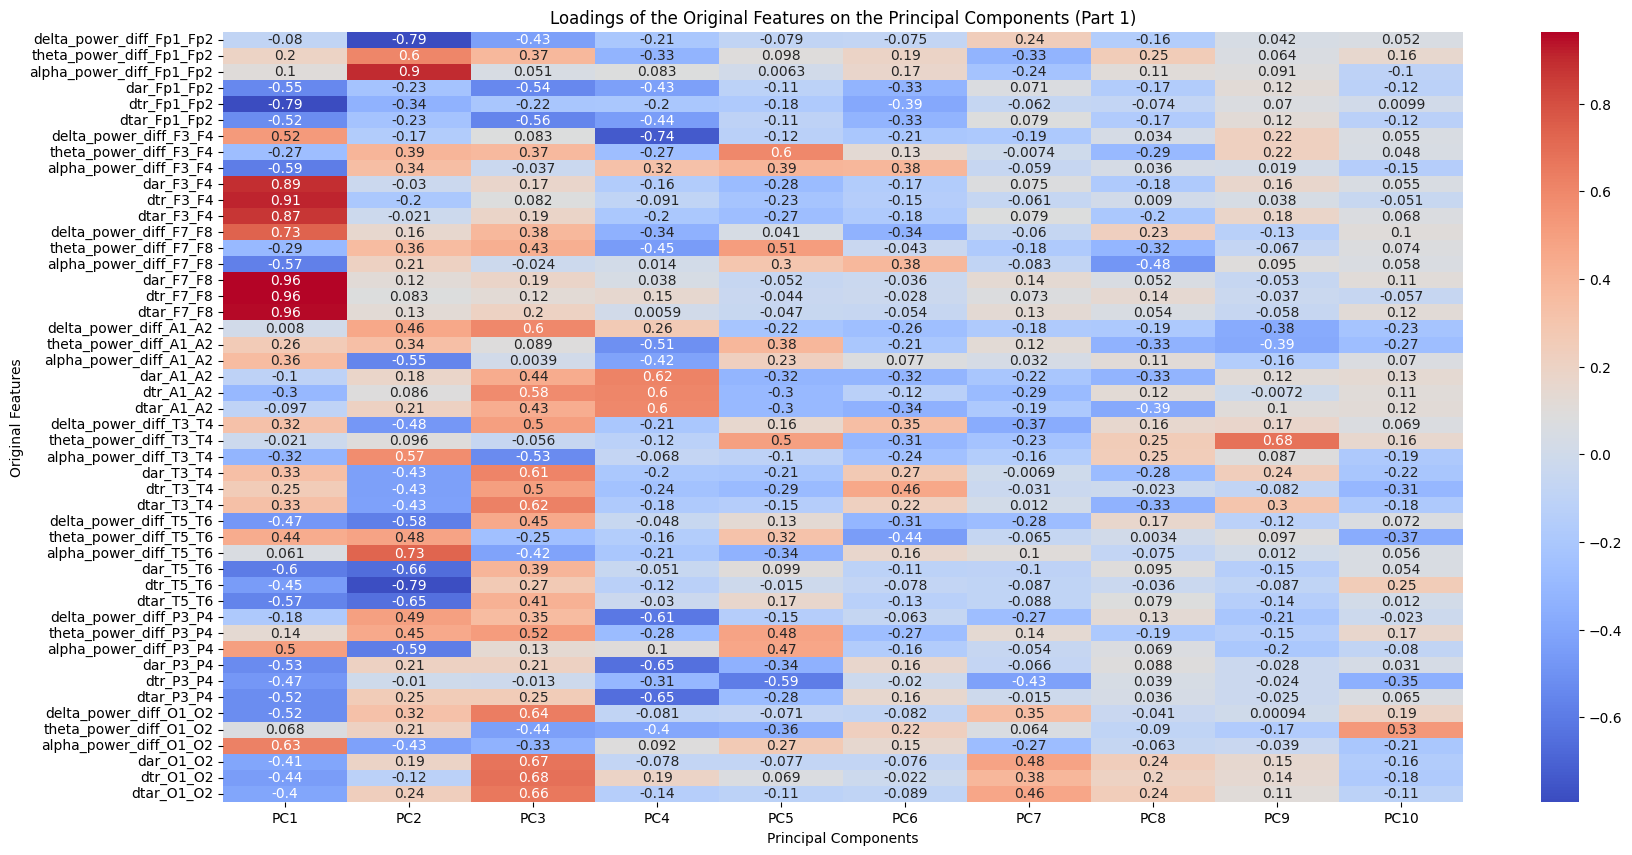

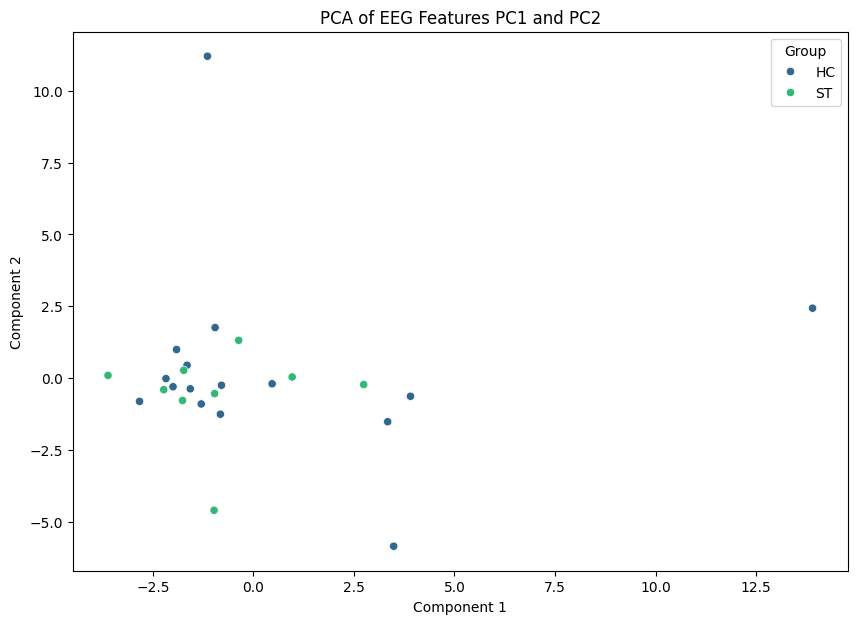

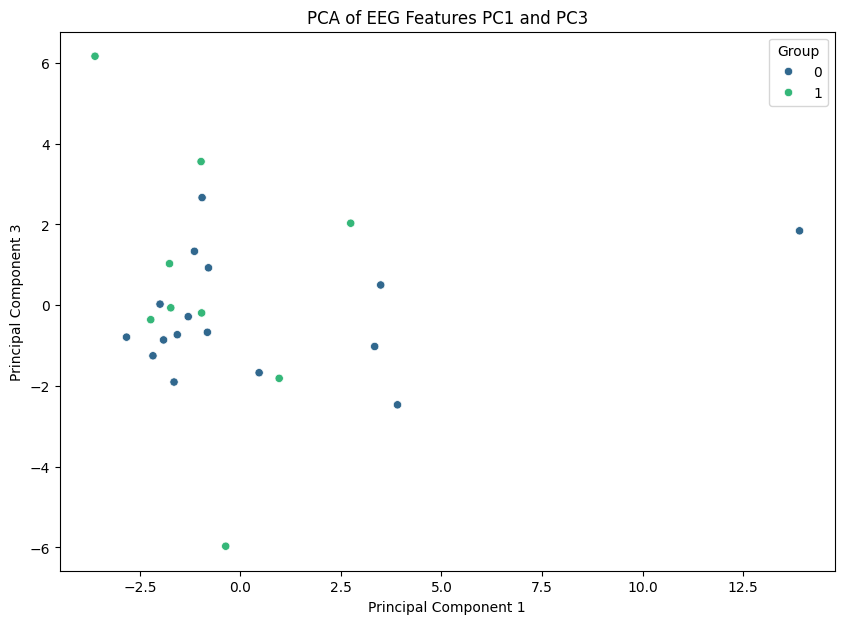

In [ ]:
# Separate features and labels
X = Data_Frame.drop(columns=['Group','id','Group_Label'])
y = Data_Frame['Group']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Variance explained by each component
explained_variance = pca.explained_variance_ratio_
# print(f'Explained variance by each component: {explained_variance}')
# print(f'Cumulative explained variance: {np.cumsum(explained_variance)}')

# Plot the explained variance
plt.figure(figsize=(10, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Loadings of the original features on the principal components
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, index=X.columns, columns=[f'PC{i+1}' for i in range(10)])
print(loadings_df)

# Assuming loadings_df is your DataFrame with loadings
n_plot = 1
num_features = len(loadings_df)
tenth_point = num_features // n_plot

# Split the loadings DataFrame into ten parts
loadings_df_parts = [loadings_df.iloc[i*tenth_point:(i+1)*tenth_point, :] for i in range(n_plot)]

# Plot each tenth of the features
for i, loadings_part in enumerate(loadings_df_parts, 1):
    plt.figure(figsize=(20, 10))
    sns.heatmap(loadings_part, annot=True, cmap='coolwarm', cbar=True, annot_kws={"size": 10})
    plt.title(f'Loadings of the Original Features on the Principal Components (Part {i})')
    plt.xlabel('Principal Components')
    plt.ylabel('Original Features')
    plt.show()


# Plot PCA
label_mapping = {0: 'HC', 1: 'ST'}
y_labels = y.map(label_mapping)
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_labels, palette='viridis')
plt.title('PCA of EEG Features PC1 and PC2')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Group', loc='best')
plt.show()

# Plot PCA
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 3], hue=y, palette='viridis')
plt.title('PCA of EEG Features PC1 and PC3')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
plt.legend(title='Group', loc='best')
plt.show()



#SVM Model

In [ ]:
# Plot decision boundaries
def plot_decision_boundaries(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, levels=[-1, 0, 1], colors=['lightblue', 'lightcoral'])

    # Plot data points with labels
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)

    # Create legend from custom artist/label lists
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.coolwarm(0.), markersize=10, label='HC'),
               plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.coolwarm(1.), markersize=10, label='ST')]
    plt.legend(handles=handles)

    plt.title(title)
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.show()

Explained variance by each component: [0.24799822 0.16660613]
Accuracy: 0.6
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.00      0.00      0.00         2

    accuracy                           0.60         5
   macro avg       0.30      0.50      0.37         5
weighted avg       0.36      0.60      0.45         5

y_test = 8     0
16    1
0     0
23    1
11    0
Name: Group, dtype: int64
y_pred = [0 0 0 0 0]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


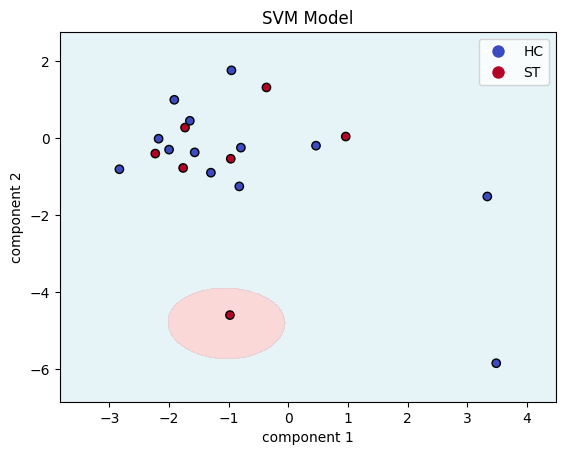

Fold 1 Classification Report
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.00      0.00      0.00         1

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5

Fold 2 Classification Report
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.00      0.00      0.00         2

    accuracy                           0.60         5
   macro avg       0.30      0.50      0.37         5
weighted avg       0.36      0.60      0.45         5

Fold 3 Classification Report
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.00      0.00      0.00         2

    accuracy                           0.60         5
   macro avg       0.30      0.50      0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

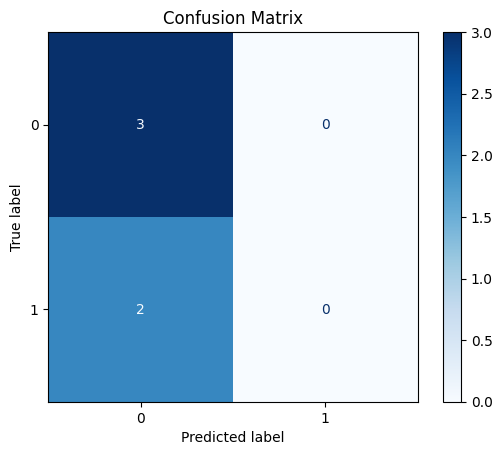

In [ ]:
# Separate features and labels
X = Data_Frame.drop(columns=['Group', 'id','Group_Label'])
y = Data_Frame['Group']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Variance explained by each component
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by each component: {explained_variance}')
# print(f'Cumulative explained variance: {np.cumsum(explained_variance)}')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Create and train the SVM model
C_Config = 1
gamma_value = 0.1
# svm_rbf = SVC(C = C_Config , gamma = gamma_value, kernel='rbf')
svm_rbf = SVC(C = C_Config, kernel='rbf')
svm_rbf.fit(X_train, y_train)

# Make predictions
y_pred_rbf = svm_rbf.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred_rbf)}")
print(classification_report(y_test, y_pred_rbf))

print(f'y_test = {y_test}')
print(f'y_pred = {y_pred_rbf}')

# Plot decision boundary for training set
plot_decision_boundaries(X_train, y_train, svm_rbf, 'SVM Model')

# Perform Stratified K-Fold Cross-Validation
stratified_kf = StratifiedKFold(n_splits=5)
scores = cross_val_score(svm_rbf, X_pca, y, cv=stratified_kf)

fold = 1
for train_index, test_index in stratified_kf.split(X_pca, y):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create and train the SVM model
    svm_rbf.fit(X_train, y_train)

    # Make predictions
    y_pred_rbf = svm_rbf.predict(X_test)

    # Print classification report for the current fold
    print(f'Fold {fold} Classification Report')
    print(classification_report(y_test, y_pred_rbf))
    fold += 1

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rbf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_rbf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

#ROC plot

Explained variance by each component: [0.38975561 0.17601289]
Accuracy: 0.875
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.67      0.80         3

    accuracy                           0.88         8
   macro avg       0.92      0.83      0.85         8
weighted avg       0.90      0.88      0.87         8

y_test = [0 0 0 1 0 0 1 1]
y_pred = [0 0 0 0 0 0 1 1]


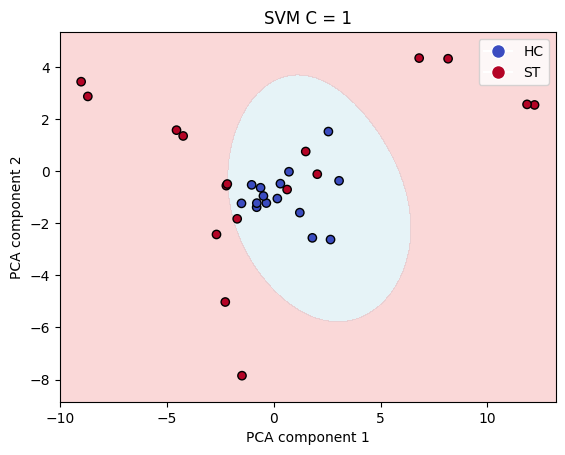

Cross-Validation Scores: [0.875 0.875 0.75  1.    0.75 ]
Mean Cross-Validation Score: 0.85


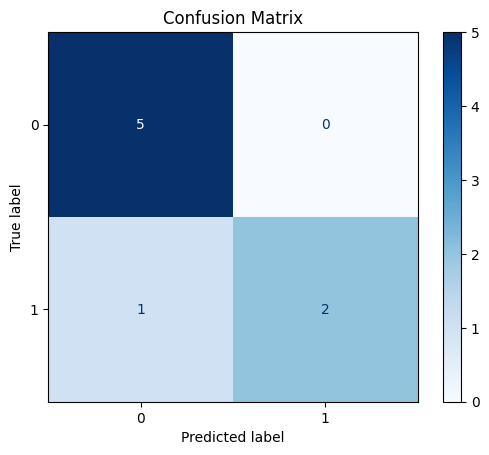

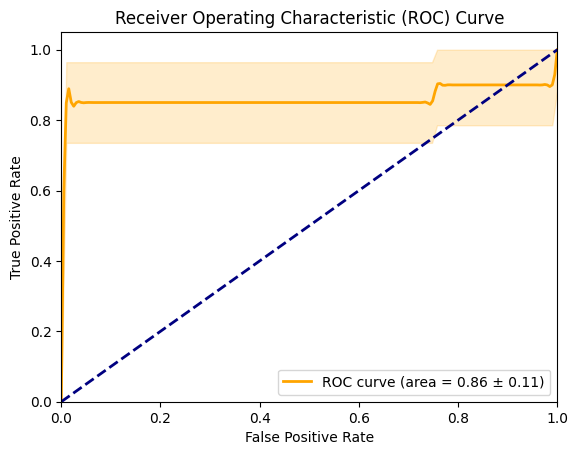

In [ ]:
# Separate features and labels
X = Data_Frame.drop(columns=['Group', 'id'])
y = Data_Frame['Group']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Variance explained by each component
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by each component: {explained_variance}')
# print(f'Cumulative explained variance: {np.cumsum(explained_variance)}')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Create and train the SVM model
C_Config = 1
svm_rbf = SVC(C=C_Config, kernel='rbf', probability=True)  # Enable probability estimates
svm_rbf.fit(X_train, y_train)

# Make predictions
y_pred_rbf = svm_rbf.predict(X_test)
y_prob_rbf = svm_rbf.predict_proba(X_test)[:, 1]  # Get the probability estimates for the positive class

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred_rbf)}")
print(classification_report(y_test, y_pred_rbf))

print(f'y_test = {y_test.values}')
print(f'y_pred = {y_pred_rbf}')

# Plot decision boundary for training set
plot_decision_boundaries(X_train, y_train, svm_rbf, 'SVM C = ' + str(C_Config))

# Perform Stratified K-Fold Cross-Validation
stratified_kf = StratifiedKFold(n_splits=5)
scores = cross_val_score(svm_rbf, X_pca, y, cv=stratified_kf)
print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rbf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_rbf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curve using Cross-Validation
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for train_index, test_index in stratified_kf.split(X_pca, y):
    X_train_cv, X_test_cv = X_pca[train_index], X_pca[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]

    svm_rbf.fit(X_train_cv, y_train_cv)
    y_prob_rbf_cv = svm_rbf.predict_proba(X_test_cv)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_cv, y_prob_rbf_cv)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    auc = roc_auc_score(y_test_cv, y_prob_rbf_cv)
    aucs.append(auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

# Smooth the ROC curve
smooth_fpr = np.linspace(0, 1, 200)
spl = make_interp_spline(mean_fpr, mean_tpr, k=3)
smooth_tpr = spl(smooth_fpr)

# Plot scatter with smooth lines
plt.figure()
# plt.scatter(mean_fpr, mean_tpr, color='blue', label='Data points')
plt.plot(smooth_fpr, smooth_tpr, color='orange', lw=2, label=f'ROC curve (area = {mean_auc:.2f} ± {std_auc:.2f})')
plt.fill_between(mean_fpr, np.maximum(mean_tpr - std_auc, 0), np.minimum(mean_tpr + std_auc, 1), color='orange', alpha=0.2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#Print True/False IDs

Accuracy: 0.875
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.67      0.80         3

    accuracy                           0.88         8
   macro avg       0.92      0.83      0.85         8
weighted avg       0.90      0.88      0.87         8

y_test = [0 0 0 1 0 0 1 1]
y_pred = [0 0 0 0 0 0 1 1]
Sensitivity: 0.6666666666666666
Specificity: 1.0
True Positive IDs: ['ST_008' 'ST_018']
True Negative IDs: ['HC_010' 'HC_007' 'HC_006' 'HC_015' 'HC_003']
False Positive IDs: []
False Negative IDs: ['ST_017']


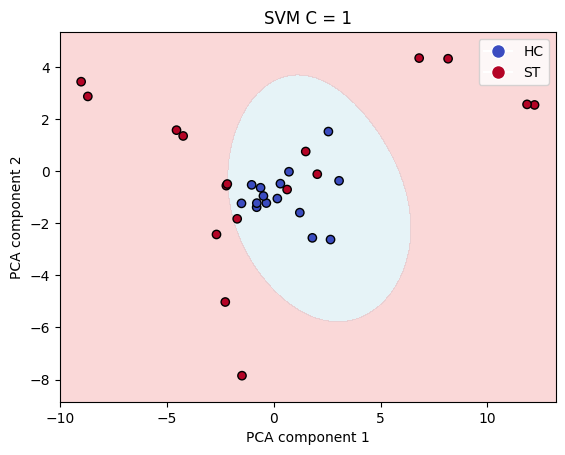

Cross-Validation Scores: [0.875 0.875 0.75  1.    0.75 ]
Mean Cross-Validation Score: 0.85


In [ ]:
# Separate features and labels
X = Data_Frame.drop(columns=['Group', 'id'])
y = Data_Frame['Group']
ids = Data_Frame['id']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Split the data into training and test sets
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X_pca, y, ids, test_size=0.2, random_state=42)

# Set the parameters
C_Config = 1
gamma_value = 0.01

# Create and train the SVM model
svm_rbf = SVC(C=C_Config, kernel='rbf')
svm_rbf.fit(X_train, y_train)

# Make predictions
y_pred_rbf = svm_rbf.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred_rbf)}")
print(classification_report(y_test, y_pred_rbf))

print(f'y_test = {y_test.values}')
print(f'y_pred = {y_pred_rbf}')

# Calculate Sensitivity (Recall)
TP = cm[1, 1]
FN = cm[1, 0]
sensitivity = TP / (TP + FN)
print(f'Sensitivity: {sensitivity}')

# Calculate Specificity
TN = cm[0, 0]
FP = cm[0, 1]
specificity = TN / (TN + FP)
print(f'Specificity: {specificity}')

# Confusion Matrix IDs
tp_ids = ids_test[(y_test == 1) & (y_pred_rbf == 1)]
tn_ids = ids_test[(y_test == 0) & (y_pred_rbf == 0)]
fp_ids = ids_test[(y_test == 0) & (y_pred_rbf == 1)]
fn_ids = ids_test[(y_test == 1) & (y_pred_rbf == 0)]

print(f'True Positive IDs: {tp_ids.values}')
print(f'True Negative IDs: {tn_ids.values}')
print(f'False Positive IDs: {fp_ids.values}')
print(f'False Negative IDs: {fn_ids.values}')

# Plot decision boundary for training set
plot_decision_boundaries(X_train, y_train, svm_rbf, 'SVM C = ' + str(C_Config))

# Perform Stratified K-Fold Cross-Validation
stratified_kf = StratifiedKFold(n_splits=5)
scores = cross_val_score(svm_rbf, X_pca, y, cv=stratified_kf)
print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')


#เพิ่ม id ในกราฟ

Explained variance by each component: [0.38975561 0.17601289]
Accuracy: 0.875
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.67      0.80         3

    accuracy                           0.88         8
   macro avg       0.92      0.83      0.85         8
weighted avg       0.90      0.88      0.87         8

y_test = 19    0
16    0
15    0
26    1
4     0
12    0
37    1
27    1
Name: Group, dtype: int64
y_pred = [0 0 0 0 0 0 1 1]


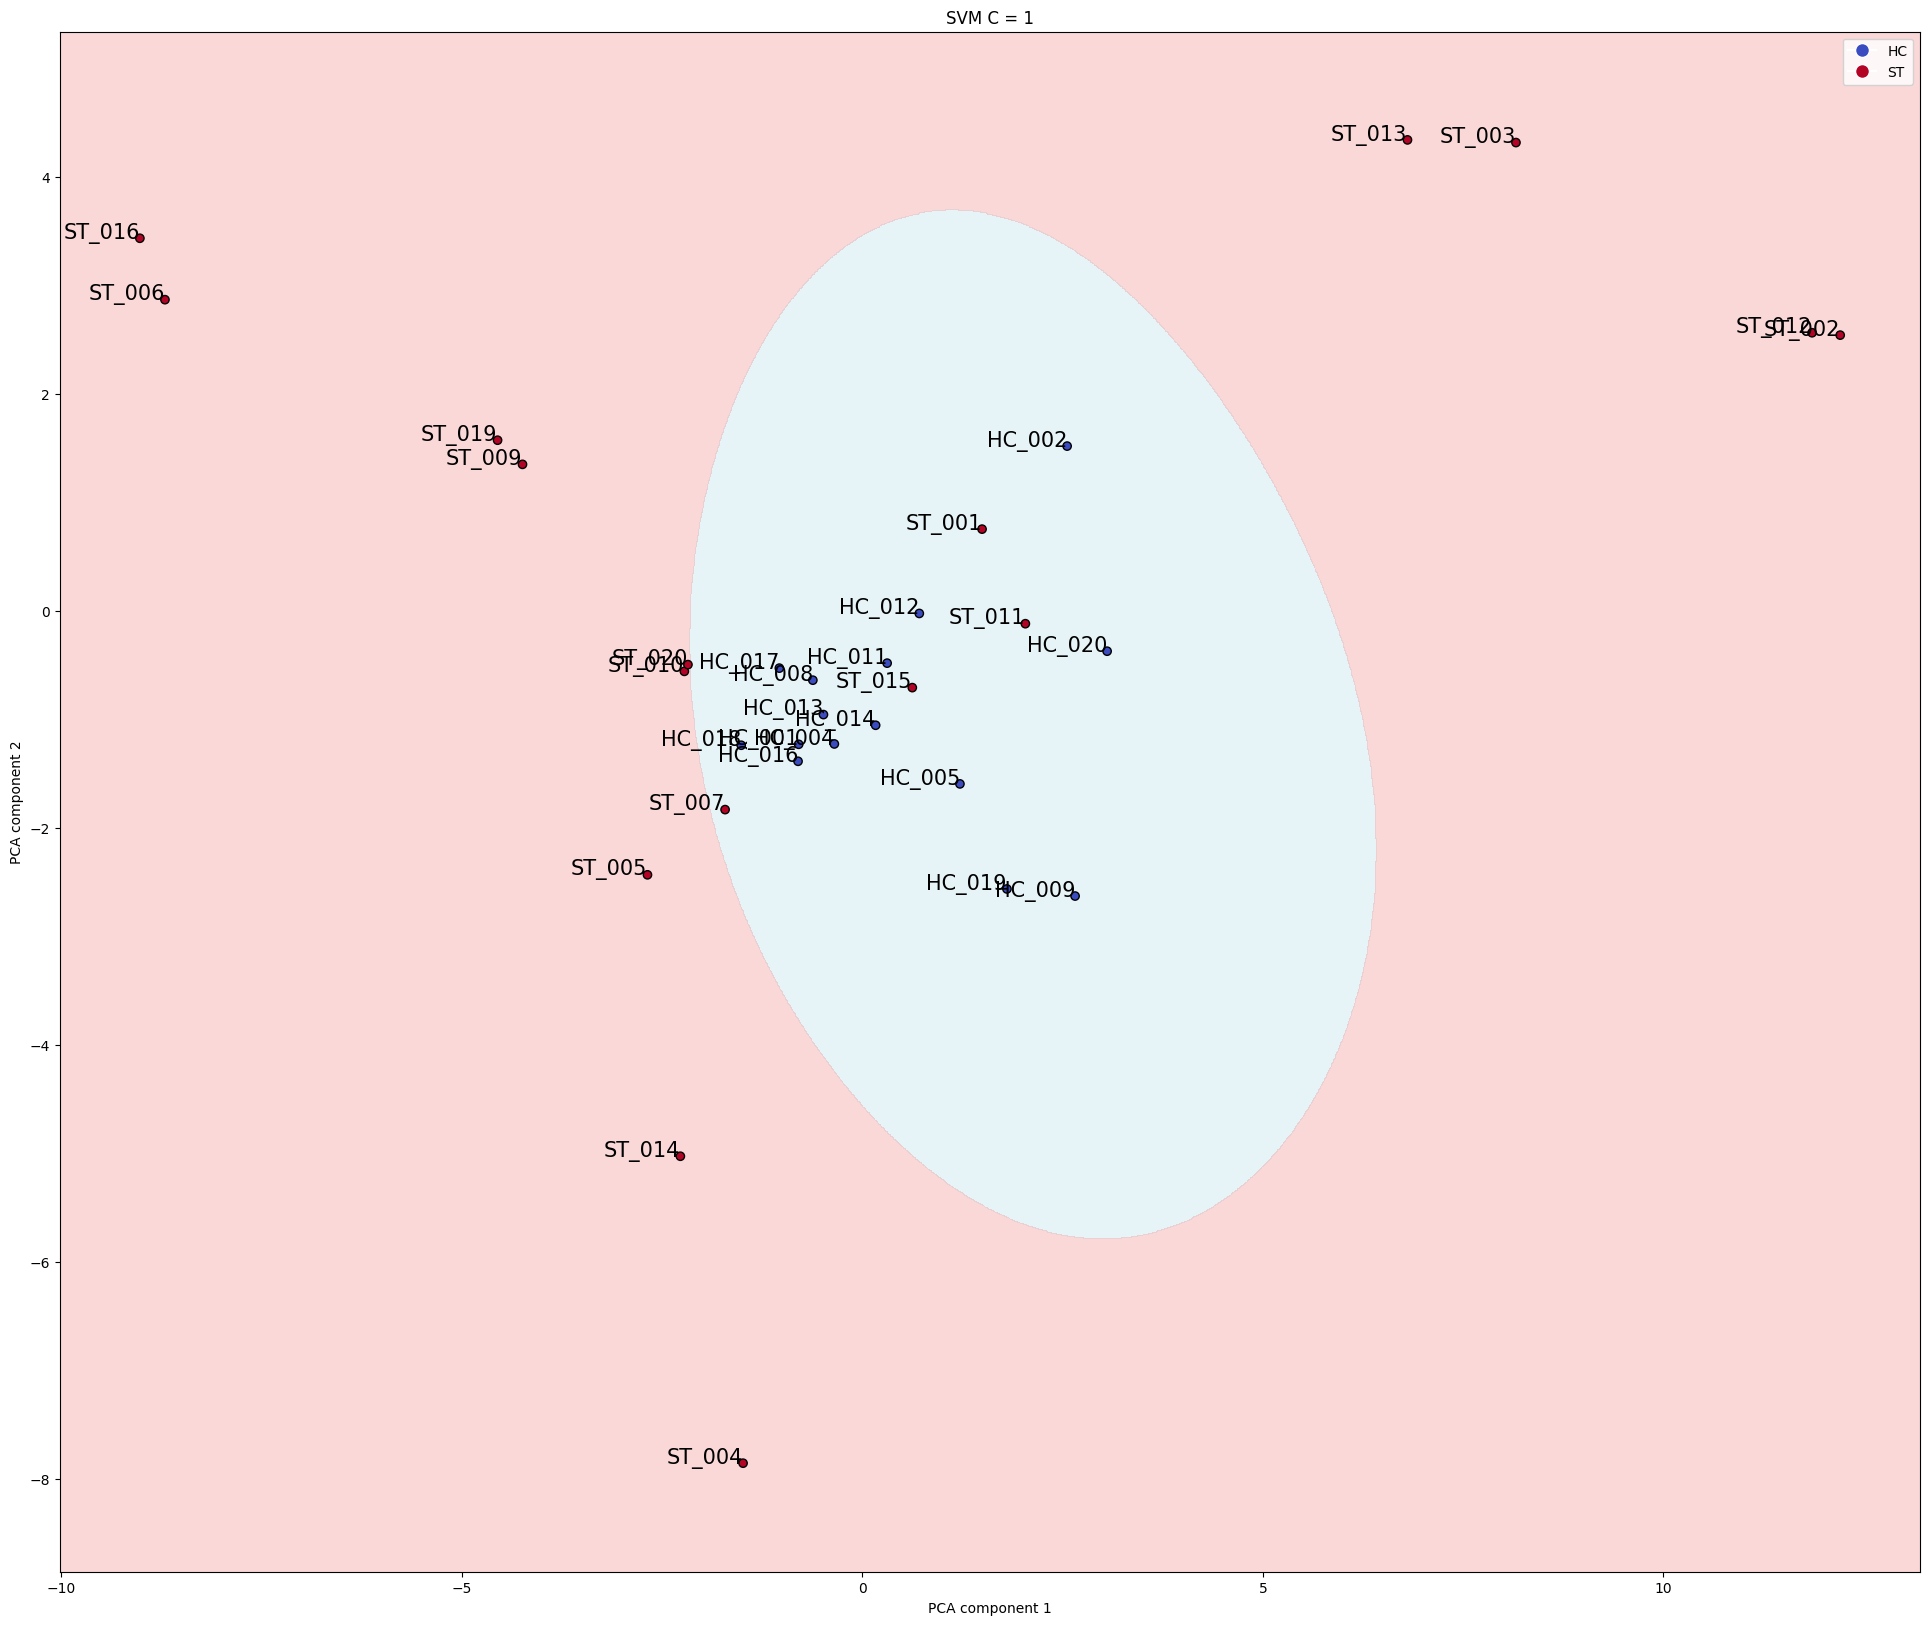

Cross-Validation Scores: [0.875 0.875 0.75  1.    0.75 ]
Mean Cross-Validation Score: 0.85


In [ ]:

def plot_decision_boundaries(X, y, model, title, ids):
    plt.figure(figsize=(24, 20))
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, levels=[-1, 0, 1], colors=['lightblue', 'lightcoral'])

    # Plot data points with labels
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
    for i, txt in enumerate(ids):
        plt.annotate(txt, (X[i, 0], X[i, 1]), fontsize=15, ha='right')

    # Create legend from custom artist/label lists
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.coolwarm(0.), markersize=10, label='HC'),
               plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.coolwarm(1.), markersize=10, label='ST')]
    plt.legend(handles=handles)

    plt.title(title)
    plt.xlabel('PCA component 1')
    plt.ylabel('PCA component 2')
    plt.show()

# Separate features and labels
X = Data_Frame.drop(columns=['Group', 'id'])
y = Data_Frame['Group']
ids = Data_Frame['id']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Variance explained by each component
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by each component: {explained_variance}')
# print(f'Cumulative explained variance: {np.cumsum(explained_variance)}')

# Split the data into training and test sets
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X_pca, y, ids, test_size=0.2, random_state=42)

# Create and train the SVM model
C_Config = 1
svm_rbf = SVC(C=C_Config, kernel='rbf')
svm_rbf.fit(X_train, y_train)

# Make predictions
y_pred_rbf = svm_rbf.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred_rbf)}")
print(classification_report(y_test, y_pred_rbf))

print(f'y_test = {y_test}')
print(f'y_pred = {y_pred_rbf}')

# Plot decision boundary for training set
plot_decision_boundaries(X_train, y_train, svm_rbf, 'SVM C = ' + str(C_Config), ids_train)

# Perform Stratified K-Fold Cross-Validation
stratified_kf = StratifiedKFold(n_splits=5)
scores = cross_val_score(svm_rbf, X_pca, y, cv=stratified_kf)
print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

#Grid Search

Explained variance by each component: [0.38975561 0.17601289]
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total

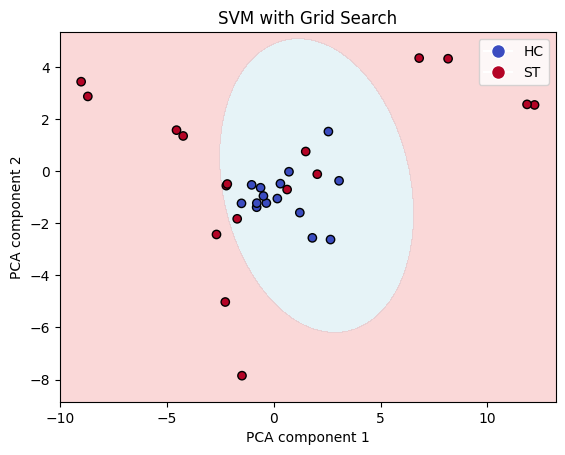

Cross-Validation Scores: [0.875 0.875 0.75  1.    0.75 ]
Mean Cross-Validation Score: 0.85


In [ ]:

# Separate features and labels
X = Data_Frame.drop(columns=['Group', 'id'])
y = Data_Frame['Group']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Variance explained by each component
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by each component: {explained_variance}')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

# Create and train the SVM model using Grid Search
grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters
print(f'Best parameters found: {grid_search.best_params_}')

# Make predictions using the best model
y_pred_rbf = grid_search.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred_rbf)}")
print(classification_report(y_test, y_pred_rbf))

print(f'y_test = {y_test}')
print(f'y_pred = {y_pred_rbf}')

# Plot decision boundary for training set
plot_decision_boundaries(X_train, y_train, grid_search.best_estimator_, 'SVM with Grid Search')

# Perform Stratified K-Fold Cross-Validation
stratified_kf = StratifiedKFold(n_splits=5)
scores = cross_val_score(grid_search.best_estimator_, X_pca, y, cv=stratified_kf)
print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')


#Random Search

Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 25 is smaller than n_iter=100. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters found: {'kernel': 'rbf', 'gamma': 0.01, 'C': 10}
Accuracy: 0.875
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.67      0.80         3

    accuracy                           0.88         8
   macro avg       0.92      0.83      0.85         8
weighted avg       0.90      0.88      0.87         8

y_test = 19    0
16    0
15    0
26    1
4     0
12    0
37    1
27    1
Name: Group, dtype: int64
y_pred = [0 0 0 0 0 0 1 1]


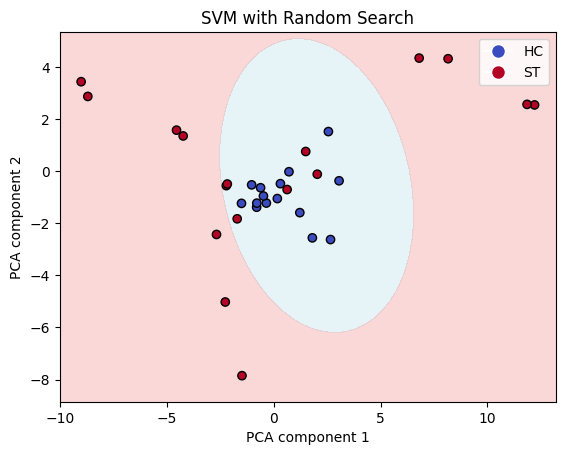

Cross-Validation Scores: [0.875 0.875 0.75  1.    0.75 ]
Mean Cross-Validation Score: 0.85


In [ ]:
# Define the parameter distribution
param_dist = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

# Create and train the SVM model using Random Search
random_search = RandomizedSearchCV(SVC(), param_distributions=param_dist, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Get the best parameters
print(f'Best parameters found: {random_search.best_params_}')

# Make predictions using the best model
y_pred_rbf = random_search.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred_rbf)}")
print(classification_report(y_test, y_pred_rbf))

print(f'y_test = {y_test}')
print(f'y_pred = {y_pred_rbf}')

# Plot decision boundary for training set
plot_decision_boundaries(X_train, y_train, random_search.best_estimator_, 'SVM with Random Search')

# Perform Stratified K-Fold Cross-Validation
stratified_kf = StratifiedKFold(n_splits=5)
scores = cross_val_score(random_search.best_estimator_, X_pca, y, cv=stratified_kf)
print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')